In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from transformers import AutoTokenizer, AutoModel,AutoModelForMaskedLM, RobertaModel, RobertaTokenizer
import torch
import torch.nn.functional as F
from torch import Tensor
from einops import rearrange
from typing import Tuple, Callable
from torch.autograd import Function
import gc
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Данные

In [4]:
from torch.utils.data import Dataset, DataLoader 
import numpy as np 
import math 

class RESDDataset(): 
    def __init__(self, part='train'): 
        if part == 'train':
            df = pd.read_csv("train.csv")
            df = df[0:int(len(df)*0.7)]
        elif part == 'valid':
            df = pd.read_csv("train.csv")
            df = df[int(len(df)*0.7):]
        elif part == 'test':
            df = pd.read_csv("test.csv")
        else:
            raise ValueError('Unknown part of RESDDataset (train / valid / test)')
        self.x = list(df['text'].values)
        transform_dict = {'anger' : 0, 'disgust' : 1, 'fear' : 2, 'sadness' : 3, 'neutral' : 4, 'happiness' : 5, 'enthusiasm' : 6}
        self.y = torch.tensor(df['emotion'].apply(lambda x : transform_dict[x]).values).to(device)
        self.n_samples = df.shape[0]  

    def __getitem__(self, index): 
        return self.x[index], self.y[index] 
        
    def __len__(self): 
        return self.n_samples 

### Feature Extractor

In [5]:
class Embedding():
    def __init__(self, model_name='jina', pooling=None):
        self.model_name = model_name
        self.pooling = pooling
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if model_name == 'jina':
            self.tokenizer = AutoTokenizer.from_pretrained("jinaai/jina-embeddings-v3", code_revision='da863dd04a4e5dce6814c6625adfba87b83838aa', trust_remote_code=True)
            self.model = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", code_revision='da863dd04a4e5dce6814c6625adfba87b83838aa', trust_remote_code=True).to(self.device)
        elif model_name == 'xlm-roberta-base':
            self.tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
            self.model = AutoModel.from_pretrained('xlm-roberta-base').to(self.device)
        elif model_name == 'canine-c':
            self.tokenizer = AutoTokenizer.from_pretrained('google/canine-c')
            self.model = AutoModel.from_pretrained('google/canine-c').to(self.device)
        else:
            raise ValueError('Unknown name of Embedding')
    def _mean_pooling(self, X):
        def mean_pooling(model_output, attention_mask):
            token_embeddings = model_output[0]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        encoded_input = self.tokenizer(X, padding=True, truncation=True, return_tensors='pt').to(self.device)
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings.unsqueeze(1)
    
    def get_embeddings(self, X):
        if self.pooling is None:
            if self.model_name == 'canine-c_emb':
                max_len = 300
            else:
                max_len = 88
            encoded_input = self.tokenizer(X, padding=True, truncation=True, return_tensors='pt').to(self.device)
            with torch.no_grad():
                features = self.model(**encoded_input)[0].detach().cpu().float().numpy()
            res = np.pad(features[:, :max_len, :], ((0, 0), (0, max(0, max_len - features.shape[1])), (0, 0)), "constant")
            return torch.tensor(res)
        elif self.pooling == 'mean':
            return self._mean_pooling(X)
        else:
            raise ValueError('Unknown type of pooling')

In [6]:
class PScan(Function):
    @staticmethod
    def forward(ctx, A_inp, X_inp):
        A, X = A_inp.clone(), X_inp.clone()
        A, X = rearrange(A, "l b d s -> b d l s"), rearrange(X, "l b d s -> b d l s")
        PScan._forward(A, X)
        ctx.save_for_backward(A.clone(), X)
        return rearrange(X, "b d l s -> b l d s")

    @staticmethod
    def backward(ctx, grad_inp: Tensor) -> Tuple[Tensor, Tensor]:
        A, X = ctx.saved_tensors
        A = torch.cat((A[:, :, :1], A[:, :, 1:].flip(2)), dim = 2)
        grad_out = rearrange(grad_inp, "b l d s -> b d l s")
        grad_out = grad_out.flip(2)
        PScan._forward(A, grad_out)
        grad_out = grad_out.flip(2)
        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_out[:, :, 1:])
        return rearrange(Q, "b d l s -> b l d s"), rearrange(grad_out, "b d l s -> b l d s")

    @staticmethod
    def _forward(A: Tensor, X: Tensor) -> None:
        b, d, l, s = A.shape
        num_steps = int(math.log2(l))
        Av, Xv = A, X
        for _ in range(num_steps):
            T = Xv.size(2)
            Av, Xv = Av[:, :, :T].reshape(b, d, T // 2, 2, -1), Xv[:, :, :T].reshape(b, d, T // 2, 2, -1)
            Xv[:, :, :, 1].add_(Av[:, :, :, 1].mul(Xv[:, :, :, 0]))
            Av[:, :, :, 1].mul_(Av[:, :, :, 0])
            Av, Xv = Av[:, :, :, 1], Xv[:, :, :, 1]
        for k in range(num_steps - 1, -1, -1):
            Av, Xv = A[:, :, 2**k - 1 : l : 2**k], X[:, :, 2**k - 1 : l : 2**k]
            T = 2 * (Xv.size(2) // 2)
            if T < Xv.size(2):
                Xv[:, :, -1].add_(Av[:, :, -1].mul(Xv[:, :, -2]))
                Av[:, :, -1].mul_(Av[:, :, -2])
            Av, Xv = Av[:, :, :T].reshape(b, d, T // 2, 2, -1), Xv[:, :, :T].reshape(b, d, T // 2, 2, -1)
            Xv[:, :, 1:, 0].add_(Av[:, :, 1:, 0].mul(Xv[:, :, :-1, 1]))
            Av[:, :, 1:, 0].mul_(Av[:, :, :-1, 1])

pscan: Callable[[Tensor, Tensor], Tensor] = PScan.apply

class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-8) -> None:
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x: Tensor) -> Tensor:        
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim = True) + self.eps) * self.weight

class MambaBlock(nn.Module):
    def __init__(self, d_input, d_model):
        super(MambaBlock, self).__init__()
        self.in_proj = nn.Linear(d_input, d_model)
        self.s_B = nn.Linear(d_model, d_model)
        self.s_C = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_input)

    def forward(self, x):
        x = x.to(device)
        x = self.in_proj(x)
        B, C = self.s_B(x), self.s_C(x)
        res = self.out_proj(x + B + C)
        return res

class Mamba(nn.Module):
    def __init__(self, num_layers, d_input, d_model, num_classes, model_name='jina', pooling=None):
        super(Mamba, self).__init__()
        self.model_name = model_name
        embed = Embedding(model_name, pooling)
        self.embedding = embed.get_embeddings
        self.layers = nn.ModuleList([MambaBlock(d_input, d_model) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_input, num_classes)

    def forward(self, seq):
        seq = torch.tensor(self.embedding(seq)).to(device)
        for mamba in self.layers:
            seq = mamba(seq)
        return self.fc_out(seq.mean(dim = 1))

In [7]:
from dataclasses import dataclass
from typing import ClassVar
from typing import List, Dict, Any, Tuple, Optional
@dataclass
class ModelTrainer:
    model: 'typing.Any'
    train_dataloader: DataLoader
    val_dataloader: DataLoader
    test_dataloader: DataLoader
    device: torch.device
    epochs: int
    round_loss: int
    round_acc: int

    optimizer: torch.optim
    loss_fn: 'typing.Any'
    
    patience: int = 5 # Ранняя остановка обучения

    class_names: ClassVar[Optional[List[str]]] = None # Список имен классов

    def __post_init__(self):
        
        # История обучения и тестирования
        self.__history = pd.DataFrame({
            "train_acc": [], # Точность на тренировочной выборке
            "test_acc": [], # Точность на тестовой выборке
            "train_loss": [], # Loss на тренировочной выборке
            "test_loss": [] # Loss на тестовой выборке
        })

        # Количество шагов в одной эпохе
        self.__train_steps = len(self.train_dataloader)
        self.__test_steps = len(self.val_dataloader)

        self.__best_test_accuracy = 0
        self.__no_improvement_count = 0
        
        self.loss_fn = self.loss_fn

    @property
    def history(self) -> pd.DataFrame:
        """Получение DataFrame историей обучения и тестирования

        Returns:
            pd.DataFrame: **DataFrame** c историей обучения и тестирования
        """

        return self.__history

    @classmethod
    def get_model_logits(cls, logits: torch.Tensor) -> torch.Tensor:
        """Получение логитов модели в зависимости от функции потерь

        Args:
            logits (torch.Tensor): Входные логиты

        Returns:
            torch.Tensor: Обработанные логиты
        """

        if isinstance(cls.loss_fn, nn.NLLLoss):
            log_softmax = nn.LogSoftmax(dim = 1)
            return log_softmax(logits)
        elif isinstance(cls.loss_fn, nn.CrossEntropyLoss):
            return logits

    def _is_best_model(self, test_accuracy: float) -> bool:
        """Проверка, является ли текущая модель лучшей на основе точности тестирования

        Args:
            test_accuracy (float): Текущая точность тестирования

        Returns:
            bool: True, если текущая модель лучшая, иначе False
        """

        try:
            max_test_acc = max(self.__history["test_acc"])
        except ValueError:
            max_test_acc = 0
        return test_accuracy > max_test_acc

    def _save_model(self, epoch: int, path_to_model: str, test_accuracy: float, loss: torch.Tensor) -> None:
        """Сохранение модели

        Args:
            epoch (int): Текущая эпоха
            path_to_model (str): Путь для сохранения модели
            test_accuracy (float): Точность на тестовой выборке
            loss (torch.Tensor): Значение потерь
        """
        
        os.makedirs(path_to_model, exist_ok = True)

        torch.save({
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "test_loss": loss,
        }, os.path.join(path_to_model, f"{self.model.__class__.__name__}_{self.model.model_name}_{epoch}_{test_accuracy}_checkpoint.pth"))
    
    # Процесс обучения
    def train(self, path_to_model: str) -> None:
        """Процесс обучения

        Args:
            path_to_model (str): Путь для сохранения моделей

        Returns:
            None
        """
        
        losses_train_list = []
        losses_test_list = []
        accuracy_train_list = []
        accuracy_test_list = []

        for epoch in range(1, self.epochs + 1):
            gc.collect()
            with torch.no_grad():
                torch.cuda.empty_cache()
            self.model.train() # Установка модели в режим обучения
            # Сумма Loss
            total_train_loss = 0
            total_test_loss = 0
            # Сумма точности
            train_accuracy = 0
            test_accuracy = 0

            # Проход по всем тренировочным пакетам
            with tqdm(total = self.__train_steps, desc = f"Эпоха {epoch}", unit = "batch") as pbar_train:
                for batch, (batch_X, targets) in enumerate(self.train_dataloader, 1):
                    logits = self.model(batch_X)
                    loss = self.loss_fn(logits, targets) # Ошибка предсказаний

                    # Обратное распространение для обновления весов
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
        
                    total_train_loss += loss.item() # Потеря
                    # Количество правильных предсказаний
                    train_accuracy += (logits.argmax(1) == targets).type(torch.float).sum().item()
        
                    pbar_train.update(1)
                    with torch.no_grad():
                        torch.cuda.empty_cache()

                # Средняя потеря
                avg_train_loss = round(total_train_loss / batch, self.round_loss)
                losses_train_list.append(avg_train_loss)
        
                # Точность
                train_accuracy = round(train_accuracy / len(self.train_dataloader.dataset) * 100, self.round_acc)
                accuracy_train_list.append(train_accuracy)
        
                pbar_train.set_postfix({
                    "Точность": train_accuracy,
                    "Средняя потеря": avg_train_loss
                })
            
            
            # Установка модели в режим предсказаний
            self.model.eval()
        
            # Предсказания на валидационной выборке
            with torch.no_grad():
                with tqdm(total = self.__test_steps, desc = f"Тестирование {epoch}", unit = "batch") as pbar_test:
                    # Проход по всем тестовым пакетам
                    for batch, (batch_X, targets) in enumerate(self.val_dataloader, 1):    
                        logits = self.model(batch_X)
                        loss = self.loss_fn(logits, targets) # Ошибка предсказаний
                        
                        total_test_loss += loss.item() # Потеря
                        # Количество правильных предсказаний
                        test_accuracy += (logits.argmax(1) == targets).type(torch.float).sum().item()
        
                        pbar_test.update(1)
                        with torch.no_grad():
                            torch.cuda.empty_cache()

                    # Средняя потеря
                    avg_test_loss = round(total_test_loss / batch, self.round_loss)
                    #print("Средняя потеря/тестовая", avg_test_loss, epoch)
                    losses_test_list.append(avg_test_loss)
        
                    # Точность
                    test_accuracy = round(test_accuracy / len(self.val_dataloader.dataset) * 100, self.round_acc)
                    #print("Точность/тестовая", test_accuracy, epoch)
                    accuracy_test_list.append(test_accuracy)
                    
                    pbar_test.set_postfix({
                        "Точность": test_accuracy,
                        "Средняя потеря": avg_test_loss
                    })
            
            if self._is_best_model(test_accuracy):
                self._save_model(epoch, path_to_model, test_accuracy, avg_test_loss)
                self._epoch = epoch
                self.__best_test_accuracy = test_accuracy
                self.__no_improvement_count = 0
            else:
                self.__no_improvement_count += 1

            # Добавлениие данных в историю обучения
            new_row = pd.Series([train_accuracy, test_accuracy, avg_train_loss, avg_test_loss], index = self.__history.columns)
            self.__history = pd.concat([self.__history, new_row.to_frame().T], ignore_index = True)

            if self.__no_improvement_count >= self.patience:
                print(f"Ранняя остановка на эпохе {epoch} из-за отсутствия улучшения точности на тестовой выборке")
                break
        self._best_model_name = f"{self.model.__class__.__name__}_{self.model.model_name}_{self._epoch}_{max(accuracy_test_list)}_checkpoint.pth"
        # Визуализация графиков потерь и точности
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(losses_train_list, label = 'Потери на тренировочной выборке')
        plt.plot(losses_test_list, label = 'Потери на валидационной выборке')
        plt.title('Потери во время обучения')
        plt.xlabel('Эпоха')
        plt.ylabel('Потери')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(accuracy_train_list, label = 'Точность на валидационной выборке')
        plt.plot(accuracy_test_list, label = 'Точность на тестовой выборке')
        plt.title('Точность во время обучения')
        plt.xlabel('Эпоха')
        plt.ylabel('Точность')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Получение хэш-значения
    def __hash__(self):
        return id(self)

In [8]:
def evaluate_metrics(model, test_dataloader):
    model.eval()
    y_test = []
    y_predict = []
    with torch.no_grad():
        for batch, (batch_X, targets) in enumerate(test_dataloader, 1):
            y_test.extend(list(map(int, targets)))
            output = model(batch_X)
            _, predictions = torch.max(output, dim=1)
            y_predict.extend(list(map(int, predictions)))
        # Unweighted Average Recall (UAR)
        uar = recall_score(y_test, y_predict, average='macro')
        # Weighted Average Recall (WAR)
        war = recall_score(y_test, y_predict, average='weighted')
        # Macro F1-score (MF1)
        mf1 = f1_score(y_test, y_predict, average='macro')
        # Weighted F1-score (WF1)
        wf1 = f1_score(y_test, y_predict, average='weighted')
    return {'uar': 100.0 * uar, 'war': 100.0 * war, 'mf1': 100.0 * mf1, 'wf1': 100.0 * wf1}

In [9]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=RESDDataset('train'), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=RESDDataset('valid'), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=RESDDataset('test'), batch_size=BATCH_SIZE, shuffle=False)

In [10]:
EPOCHS = 50 # Количество эпох
LEARNING_RATE = 1e-4 # Скорость обучения
ROUND_ACC = 2 # Знаков Accuracy после запятой
ROUND_LOSS = 7 # Знаков Loss после запятой
# Проверка наличия GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_DIR = os.path.join(".")
PATH_TO_MODEL = os.path.join(ROOT_DIR, "models_RESD_jina_experiments")

In [10]:
intervals = {
    "d_model" : [32, 64, 128, 256, 512],
    "num_layers" : [1, 2, 4, 6, 8, 10],
    "lr" : [1e-4, 1e-3, 1e-2],
    "optimizer" : [optim.Adam, optim.AdamW, optim.Rprop, optim.RMSprop, optim.RAdam]
}

In [11]:
from sklearn.utils.class_weight import compute_class_weight
y = []
for batch, (batch_X, targets) in enumerate(train_dataloader, 1):
    y.extend(list(map(int, targets)))
class_weights = torch.tensor(compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y), dtype=torch.float).to(device)

In [17]:
%%capture --no-stdout
result = []
for d_model in [32, 64, 128, 256, 512]:
    for num_layers in [1, 2, 4, 6, 8, 10]:
        print(f"d_model={d_model}, num_layers={num_layers}")
        model_mamba = Mamba(model_name='jina', pooling=None, num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
        optimizer = optim.AdamW(params = model_mamba.parameters(), lr = 1e-4)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
        trainer.train(PATH_TO_MODEL)
        checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
        model_mamba.load_state_dict(checkpoint['model_state_dict'])
        metrics_val = evaluate_metrics(model_mamba, val_dataloader)
        print("Метрики на валидационной выборке: ", metrics_val)
        metrics_test = evaluate_metrics(model_mamba, test_dataloader)
        print("Метрики на тестовой выборке: ", metrics_test)
        result.append([{"d_model" : d_model, "num_layers": num_layers}, metrics_val, metrics_test, trainer._best_model_name])

d_model=32, num_layers=1
Ранняя остановка на эпохе 26 из-за отсутствия улучшения точности на тестовой выборке
Метрики на валидационной выборке:  {'uar': 37.04028567948918, 'war': 37.61194029850746, 'mf1': 36.43342047613953, 'wf1': 37.10774009157733}
Метрики на тестовой выборке:  {'uar': 34.99309545362178, 'war': 35.0, 'mf1': 34.90306307148634, 'wf1': 35.11272746072866}
d_model=32, num_layers=2
Ранняя остановка на эпохе 30 из-за отсутствия улучшения точности на тестовой выборке
Метрики на валидационной выборке:  {'uar': 36.12562899555957, 'war': 36.11940298507463, 'mf1': 35.52529844447952, 'wf1': 35.80021111375592}
Метрики на тестовой выборке:  {'uar': 35.25820719899667, 'war': 35.35714285714286, 'mf1': 34.71898176031404, 'wf1': 35.04744244060082}
d_model=32, num_layers=4
Ранняя остановка на эпохе 30 из-за отсутствия улучшения точности на тестовой выборке
Метрики на валидационной выборке:  {'uar': 36.52221564954484, 'war': 37.014925373134325, 'mf1': 36.30542993017828, 'wf1': 36.77922787

In [20]:
df = pd.DataFrame(result, columns=["параметры", "метрики val", "метрики test", "путь"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики val"].apply(pd.Series), df["метрики test"].apply(pd.Series), df["путь"]], axis=1)
df.columns = ["d_model", "num_layers", "uar_val", "war_val", "mf1_val", "wf1_val", "uar_test", "war_test", "mf1_test", "wf1_test", "путь"]
df

,d_model,num_layers,uar_val,war_val,mf1_val,wf1_val,uar_test,war_test,mf1_test,wf1_test,путь
0,32,1,37.040286,37.611940,36.433420,37.107740,34.993095,35.000000,34.903063,35.112727,Mamba_jina_16_40.0_checkpoint.pth
1,32,2,36.125629,36.119403,35.525298,35.800211,35.258207,35.357143,34.718982,35.047442,Mamba_jina_20_36.12_checkpoint.pth
2,32,4,36.522216,37.014925,36.305430,36.779228,32.590835,32.857143,32.527404,32.910996,Mamba_jina_20_37.31_checkpoint.pth
3,32,6,29.860125,30.447761,27.412081,27.897604,23.571447,24.642857,21.916354,22.743230,Mamba_jina_10_31.34_checkpoint.pth
4,32,8,31.378908,30.746269,29.802233,29.803487,23.675589,23.928571,23.548179,23.806482,Mamba_jina_22_30.45_checkpoint.pth
5,32,10,21.122227,22.089552,16.765553,17.567289,21.851429,23.571429,17.332939,18.503758,Mamba_jina_11_23.88_checkpoint.pth
6,64,1,37.935556,38.507463,37.997130,38.837849,36.808429,36.785714,36.162149,36.383694,Mamba_jina_15_38.51_checkpoint.pth
7,64,2,39.088988,40.000000,38.689983,39.439001,38.901203,39.642857,38.635691,39.208851,Mamba_jina_13_40.6_checkpoint.pth
8,64,4,37.312103,37.611940,36.950158,37.332493,31.590265,31.785714,31.272524,31.442696,Mamba_jina_23_38.81_checkpoint.pth
9,64,6,37.373950,38.507463,36.674191,37.612037,34.185152,34.642857,34.243924,34.405099,Mamba_jina_26_37.91_checkpoint.pth


In [19]:
df.to_csv(os.path.join(PATH_TO_MODEL, "result_d_model_num_layers.csv"))

### d_model=64, num_layers=2

In [22]:
optim_dict = {"Adam" : optim.Adam, "AdamW" : optim.AdamW, "Rprop" : optim.Rprop, "RMSprop" : optim.RMSprop, "RAdam" : optim.RAdam}

In [ ]:
%%capture --no-stdout
result = []
for optimizer_ in ["Adam", "AdamW", "Rprop", "RMSprop", "RAdam"]:
    for lr in [1e-3, 1e-4, 1e-5]:
        print(f"lr={lr}, optimizer={optimizer_}")
        model_mamba = Mamba(model_name='jina', pooling=None, num_layers = 2, d_input = 1024, d_model = 64, num_classes=7).to(device)
        optimizer = optim_dict[optimizer_](params = model_mamba.parameters(), lr = lr)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
        trainer.train(PATH_TO_MODEL)
        checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
        model_mamba.load_state_dict(checkpoint['model_state_dict'])
        metrics_val = evaluate_metrics(model_mamba, val_dataloader)
        print("Метрики на валидационной выборке: ", metrics_val)
        metrics_test = evaluate_metrics(model_mamba, test_dataloader)
        print("Метрики на тестовой выборке: ", metrics_test)
        result.append([{"lr" : lr, "optimizer": optimizer_}, metrics_val, metrics_test, trainer._best_model_name])

lr=0.001, optimizer=Adam
Ранняя остановка на эпохе 17 из-за отсутствия улучшения точности на тестовой выборке
Метрики на валидационной выборке:  {'uar': 37.405375676840784, 'war': 37.61194029850746, 'mf1': 36.92953402851396, 'wf1': 37.216033109356225}
Метрики на тестовой выборке:  {'uar': 39.00010571063203, 'war': 39.285714285714285, 'mf1': 38.11638104576869, 'wf1': 38.25533534230907}
lr=0.0001, optimizer=Adam
Ранняя остановка на эпохе 21 из-за отсутствия улучшения точности на тестовой выборке
Метрики на валидационной выборке:  {'uar': 37.11654516879216, 'war': 37.61194029850746, 'mf1': 36.38072583599654, 'wf1': 36.98251205908469}
Метрики на тестовой выборке:  {'uar': 41.044015649278805, 'war': 40.714285714285715, 'mf1': 39.75107581284229, 'wf1': 39.79595789217106}
lr=1e-05, optimizer=Adam
Метрики на валидационной выборке:  {'uar': 38.90098261526833, 'war': 39.40298507462687, 'mf1': 38.72588417752506, 'wf1': 39.35627169277921}
Метрики на тестовой выборке:  {'uar': 32.14017717307191, 'w

In [ ]:
df = pd.DataFrame(result, columns=["параметры", "метрики val", "метрики test", "путь"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики val"].apply(pd.Series), df["метрики test"].apply(pd.Series), df["путь"]], axis=1)
df.columns = ["lr", "optimizer", "uar_val", "war_val", "mf1_val", "wf1_val", "uar_test", "war_test", "mf1_test", "wf1_test", "путь"]
df.to_csv(os.path.join(PATH_TO_MODEL, "result_lr_optimizer.csv"))

In [12]:
df = pd.read_csv(os.path.join(PATH_TO_MODEL, "result_lr_optimizer.csv"))

In [13]:
df

,Unnamed: 0,lr,optimizer,uar_val,war_val,mf1_val,wf1_val,uar_test,war_test,mf1_test,wf1_test,путь
0,0,0.00100,Adam,37.405376,37.611940,36.929534,37.216033,39.000106,39.285714,38.116381,38.255335,Mamba_jina_7_37.91_checkpoint.pth
1,1,0.00010,Adam,37.116545,37.611940,36.380726,36.982512,41.044016,40.714286,39.751076,39.795958,Mamba_jina_11_37.61_checkpoint.pth
2,2,0.00001,Adam,38.900983,39.402985,38.725884,39.356272,32.140177,32.142857,31.990225,32.214321,Mamba_jina_48_39.1_checkpoint.pth
3,3,0.00100,AdamW,38.665273,39.701493,38.932483,39.690207,31.957361,32.857143,30.592440,31.326350,Mamba_jina_7_40.6_checkpoint.pth
4,4,0.00010,AdamW,38.349086,38.507463,37.656665,37.981513,36.887502,36.785714,36.054740,36.361352,Mamba_jina_10_38.81_checkpoint.pth
5,5,0.00001,AdamW,37.578098,38.208955,37.449364,38.240872,30.229192,30.357143,29.846677,30.248024,Mamba_jina_48_38.21_checkpoint.pth
6,6,0.00100,Rprop,35.376710,35.522388,35.178361,35.591594,31.978132,32.500000,31.454552,31.947887,Mamba_jina_9_35.22_checkpoint.pth
7,7,0.00010,Rprop,25.590096,27.761194,20.510774,21.757210,20.485164,22.142857,15.877351,16.789709,Mamba_jina_4_27.76_checkpoint.pth
8,8,0.00001,Rprop,27.527314,27.761194,26.753933,27.134755,26.345052,26.428571,25.585979,25.681534,Mamba_jina_44_28.06_checkpoint.pth
9,9,0.00100,RMSprop,38.715368,40.000000,37.668778,38.455118,31.538951,32.500000,30.689659,31.389188,Mamba_jina_14_39.7_checkpoint.pth


In [11]:
N_ITER = 10

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=32, num_layers=1, lr=0.0001, optimizer=RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0
    weight_decay: 0
)


Тестирование 20: 100%|██████████| 11/11 [00:07<00:00,  1.52batch/s, Точность=35.2, Средняя потеря=1.8]


Максимальная точность на валидационной выборке = 38.81, модель = 'Mamba_jina_emb_19_38.81_checkpoint.pth'


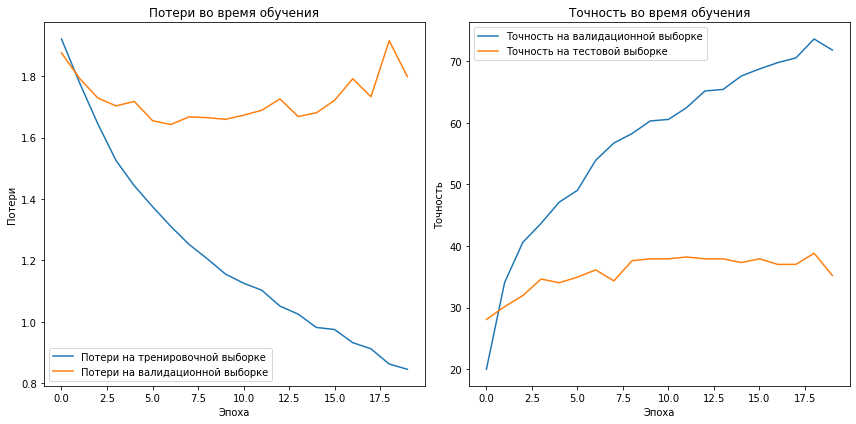

Метрики на тестовой выборке:  {'uar': 33.627797739639846, 'war': 34.64285714285714, 'mf1': 33.214258677353264, 'wf1': 34.098711840373944}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=32, num_layers=4, lr=0.001, optimizer=RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)


Тестирование 20: 100%|██████████| 11/11 [00:07<00:00,  1.53batch/s, Точность=33.1, Средняя потеря=1.92]


Максимальная точность на валидационной выборке = 33.13, модель = 'Mamba_jina_emb_20_33.13_checkpoint.pth'


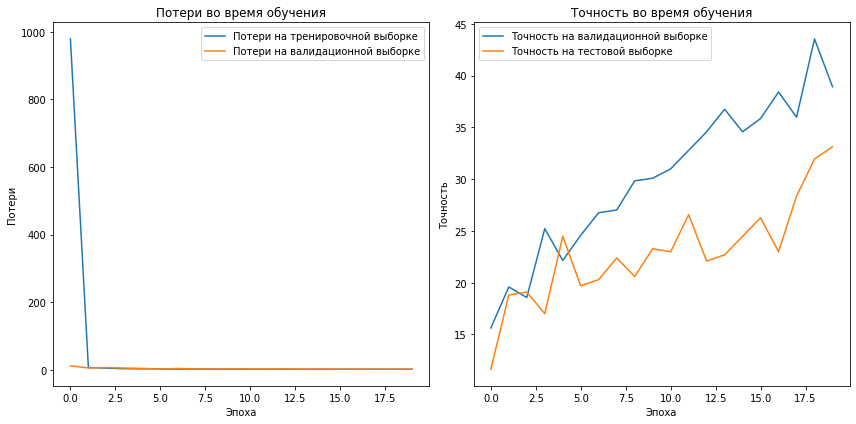

Метрики на тестовой выборке:  {'uar': 28.53163441979231, 'war': 29.642857142857142, 'mf1': 26.603556418114877, 'wf1': 27.309631216975177}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=1, lr=0.001, optimizer=RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)


Тестирование 17: 100%|██████████| 11/11 [00:07<00:00,  1.55batch/s, Точность=36.1, Средняя потеря=2.29]


Ранняя остановка на эпохе 17 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 36.42, модель = 'Mamba_jina_emb_7_36.42_checkpoint.pth'


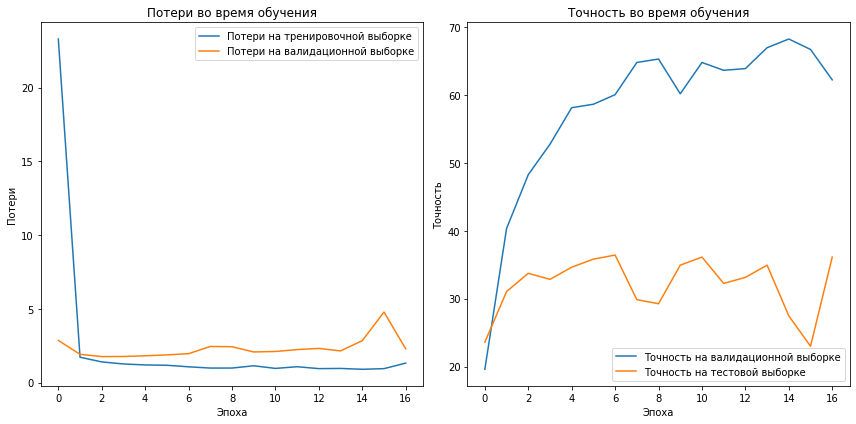

Метрики на тестовой выборке:  {'uar': 29.594303377198113, 'war': 30.714285714285715, 'mf1': 25.9980992804122, 'wf1': 26.416739518355165}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=128, num_layers=10, lr=0.01, optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)


Тестирование 20: 100%|██████████| 11/11 [00:07<00:00,  1.52batch/s, Точность=17, Средняя потеря=1.18e+16]


Максимальная точность на валидационной выборке = 22.09, модель = 'Mamba_jina_emb_13_22.09_checkpoint.pth'


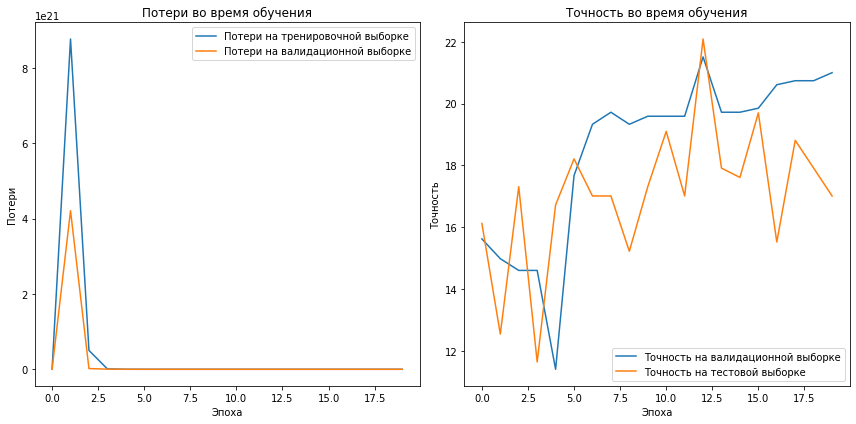

Метрики на тестовой выборке:  {'uar': 18.135975175448856, 'war': 18.571428571428573, 'mf1': 17.43611241678816, 'wf1': 17.631733193206674}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=512, num_layers=1, lr=0.001, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.001
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 12: 100%|██████████| 11/11 [00:07<00:00,  1.56batch/s, Точность=36.4, Средняя потеря=1.6]


Ранняя остановка на эпохе 12 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 36.72, модель = 'Mamba_jina_emb_2_36.72_checkpoint.pth'


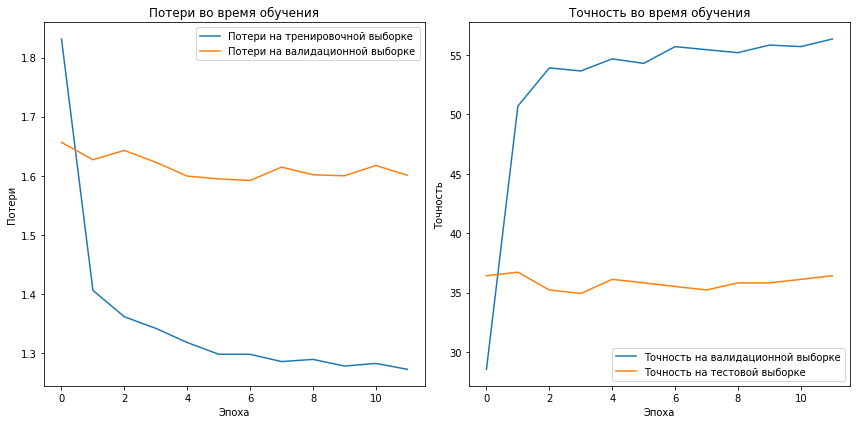

Метрики на тестовой выборке:  {'uar': 36.76052718815876, 'war': 37.857142857142854, 'mf1': 36.0300614015458, 'wf1': 36.56963859840419}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=512, num_layers=10, lr=0.01, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.01
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 14: 100%|██████████| 11/11 [00:06<00:00,  1.67batch/s, Точность=15.2, Средняя потеря=1.2e+13]


Ранняя остановка на эпохе 14 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 21.49, модель = 'Mamba_jina_emb_4_21.49_checkpoint.pth'


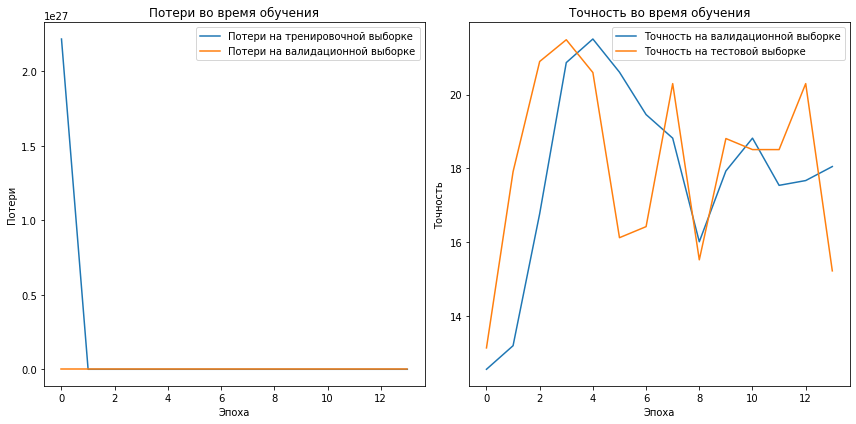

Метрики на тестовой выборке:  {'uar': 18.975864107443055, 'war': 19.642857142857142, 'mf1': 16.27080323580797, 'wf1': 16.917206498719978}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=8, lr=0.01, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


Тестирование 18: 100%|██████████| 11/11 [00:06<00:00,  1.68batch/s, Точность=12.2, Средняя потеря=6.15e+16]


Ранняя остановка на эпохе 18 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 19.4, модель = 'Mamba_jina_emb_8_19.4_checkpoint.pth'


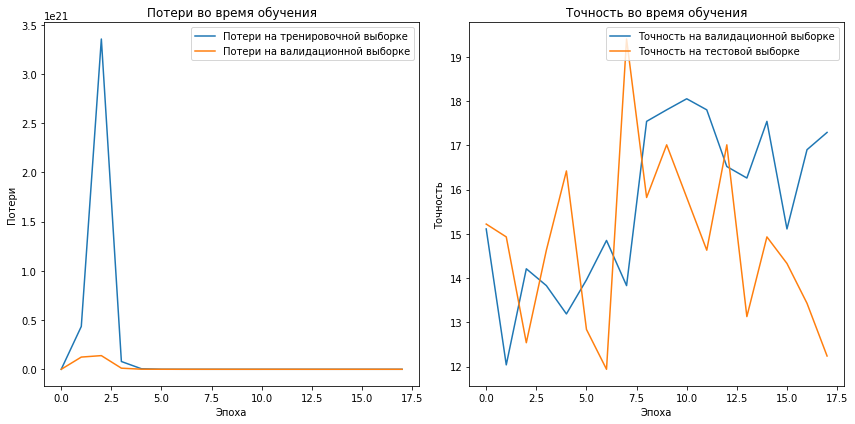

Метрики на тестовой выборке:  {'uar': 18.42934527145054, 'war': 16.785714285714285, 'mf1': 14.36774185091403, 'wf1': 13.528153791756182}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=32, num_layers=10, lr=0.01, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


Тестирование 18: 100%|██████████| 11/11 [00:06<00:00,  1.67batch/s, Точность=14.9, Средняя потеря=8.61e+15]


Ранняя остановка на эпохе 18 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 18.51, модель = 'Mamba_jina_emb_8_18.51_checkpoint.pth'


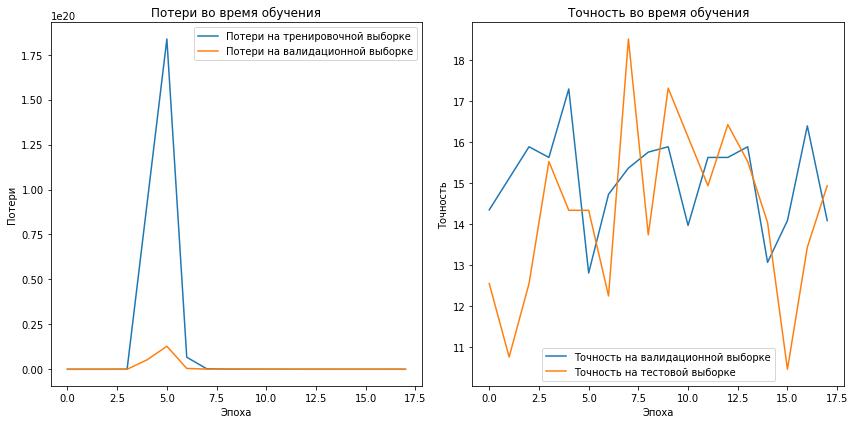

Метрики на тестовой выборке:  {'uar': 19.09071922229817, 'war': 20.0, 'mf1': 14.060610488778138, 'wf1': 14.834317785904638}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=4, lr=0.01, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.01
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 20: 100%|██████████| 11/11 [00:07<00:00,  1.50batch/s, Точность=26.9, Средняя потеря=1.99]


Максимальная точность на валидационной выборке = 28.96, модель = 'Mamba_jina_emb_12_28.96_checkpoint.pth'


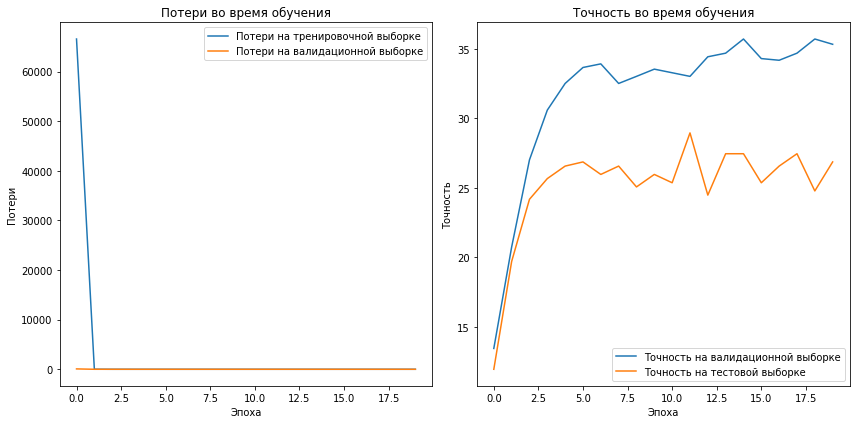

Метрики на тестовой выборке:  {'uar': 26.33422212369581, 'war': 27.142857142857142, 'mf1': 25.946469734783644, 'wf1': 26.33125161127691}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=128, num_layers=1, lr=0.001, optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


Тестирование 14: 100%|██████████| 11/11 [00:07<00:00,  1.50batch/s, Точность=35.8, Средняя потеря=3.22]


Ранняя остановка на эпохе 14 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 38.51, модель = 'Mamba_jina_emb_4_38.51_checkpoint.pth'


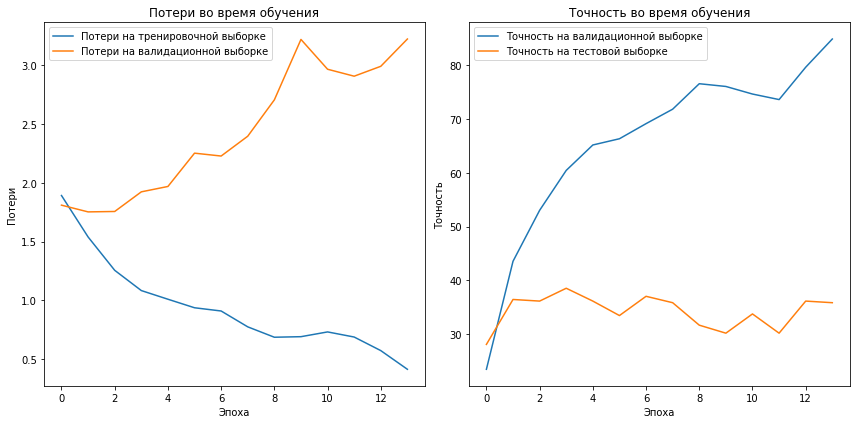

Метрики на тестовой выборке:  {'uar': 36.718943396574986, 'war': 36.78571428571429, 'mf1': 35.85845696627305, 'wf1': 36.12840567746506}


In [13]:
result = []
for it in range(N_ITER):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina_emb', num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    print(f"Параметры: d_model={d_model}, num_layers={num_layers}, lr={lr}, optimizer={optimizer}")
    loss_fn = nn.CrossEntropyLoss()
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics])

In [14]:
df = pd.DataFrame(result, columns=["параметры", "метрики"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики"].apply(pd.Series)], axis=1)
df

,d_model,num_layers,lr,optimizer,uar,war,mf1,wf1
0,32,1,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,33.627798,34.642857,33.214259,34.098712
1,32,4,0.0010,RMSprop (\nParameter Group 0\n alpha: 0.99\...,28.531634,29.642857,26.603556,27.309631
2,256,1,0.0010,RMSprop (\nParameter Group 0\n alpha: 0.99\...,29.594303,30.714286,25.998099,26.416740
3,128,10,0.0100,AdamW (\nParameter Group 0\n amsgrad: False...,18.135975,18.571429,17.436112,17.631733
4,512,1,0.0010,Rprop (\nParameter Group 0\n capturable: Fa...,36.760527,37.857143,36.030061,36.569639
5,512,10,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,18.975864,19.642857,16.270803,16.917206
6,256,8,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,18.429345,16.785714,14.367742,13.528154
7,32,10,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,19.090719,20.000000,14.060610,14.834318
8,64,4,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,26.334222,27.142857,25.946470,26.331252
9,128,1,0.0010,AdamW (\nParameter Group 0\n amsgrad: False...,36.718943,36.785714,35.858457,36.128406


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=512, num_layers=6, lr=0.0001, optimizer=RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


Тестирование 20: 100%|██████████| 11/11 [00:06<00:00,  1.73batch/s, Точность=30.8, Средняя потеря=2.66]


Максимальная точность на валидационной выборке = 37.01, модель = 'Mamba_jina_emb_17_37.01_checkpoint.pth'


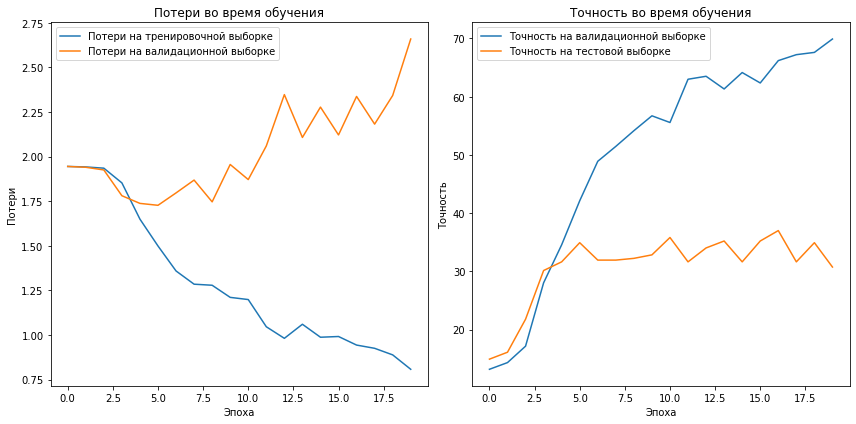

Метрики на тестовой выборке:  {'uar': 33.528643989170305, 'war': 34.285714285714285, 'mf1': 33.88231121488747, 'wf1': 34.38572034723535}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=512, num_layers=6, lr=0.001, optimizer=RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Тестирование 15: 100%|██████████| 11/11 [00:06<00:00,  1.70batch/s, Точность=23, Средняя потеря=1.9]


Ранняя остановка на эпохе 15 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 28.96, модель = 'Mamba_jina_emb_5_28.96_checkpoint.pth'


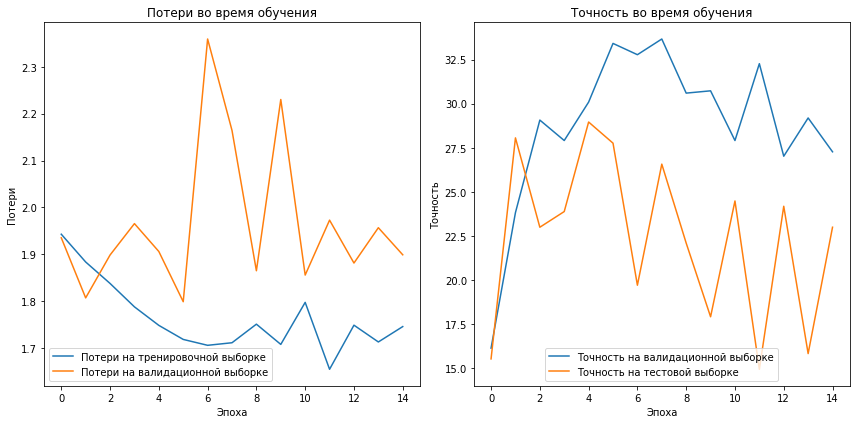

Метрики на тестовой выборке:  {'uar': 21.12781954887218, 'war': 23.214285714285715, 'mf1': 15.983242242782028, 'wf1': 17.438535953884085}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=10, lr=0.0001, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.0001
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 20: 100%|██████████| 11/11 [00:06<00:00,  1.70batch/s, Точность=21.2, Средняя потеря=1.85]


Максимальная точность на валидационной выборке = 23.28, модель = 'Mamba_jina_emb_18_23.28_checkpoint.pth'


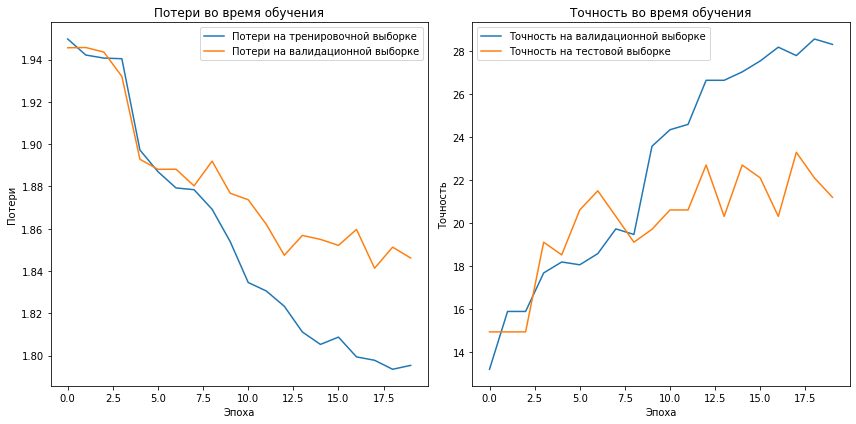

Метрики на тестовой выборке:  {'uar': 21.66944798523746, 'war': 22.857142857142858, 'mf1': 18.260746544874547, 'wf1': 19.072987426826018}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=6, lr=0.0001, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


Тестирование 20: 100%|██████████| 11/11 [00:06<00:00,  1.71batch/s, Точность=30.1, Средняя потеря=2.82]


Максимальная точность на валидационной выборке = 34.33, модель = 'Mamba_jina_emb_11_34.33_checkpoint.pth'


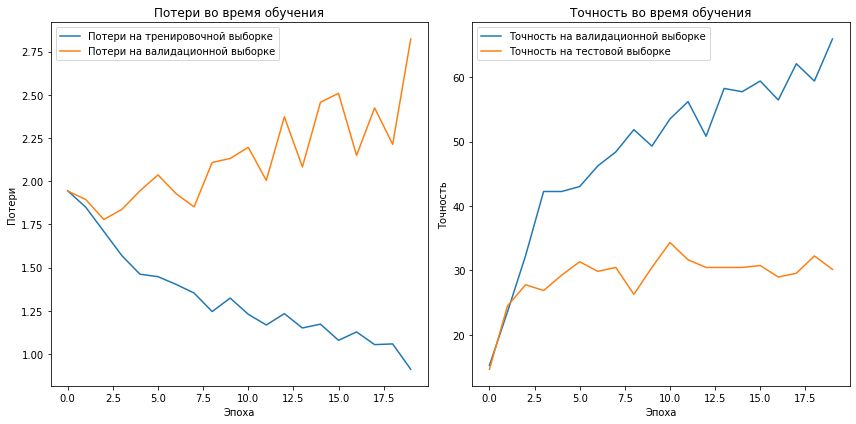

Метрики на тестовой выборке:  {'uar': 28.426244511770832, 'war': 29.642857142857142, 'mf1': 27.38422836793764, 'wf1': 28.191162580573607}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=8, lr=0.01, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


Тестирование 19: 100%|██████████| 11/11 [00:06<00:00,  1.72batch/s, Точность=13.7, Средняя потеря=3.31e+13]


Ранняя остановка на эпохе 19 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 17.31, модель = 'Mamba_jina_emb_9_17.31_checkpoint.pth'


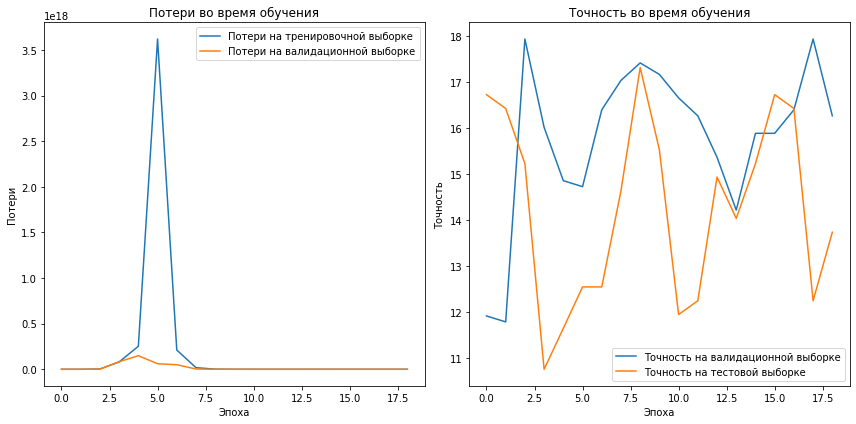

Метрики на тестовой выборке:  {'uar': 15.273146523146524, 'war': 16.071428571428573, 'mf1': 12.574202494626899, 'wf1': 13.257260962831252}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=6, lr=0.01, optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)


Тестирование 20: 100%|██████████| 11/11 [00:06<00:00,  1.71batch/s, Точность=14.6, Средняя потеря=3.98e+6]


Максимальная точность на валидационной выборке = 20.6, модель = 'Mamba_jina_emb_15_20.6_checkpoint.pth'


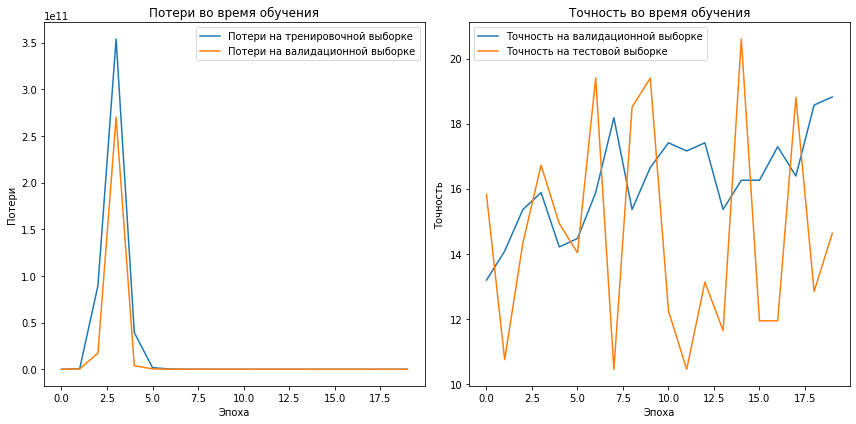

Метрики на тестовой выборке:  {'uar': 14.06356801093643, 'war': 15.357142857142858, 'mf1': 7.9691771806187885, 'wf1': 8.641871296196195}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=4, lr=0.01, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.01
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 20: 100%|██████████| 11/11 [00:06<00:00,  1.71batch/s, Точность=26, Средняя потеря=2.21]


Максимальная точность на валидационной выборке = 26.57, модель = 'Mamba_jina_emb_17_26.57_checkpoint.pth'


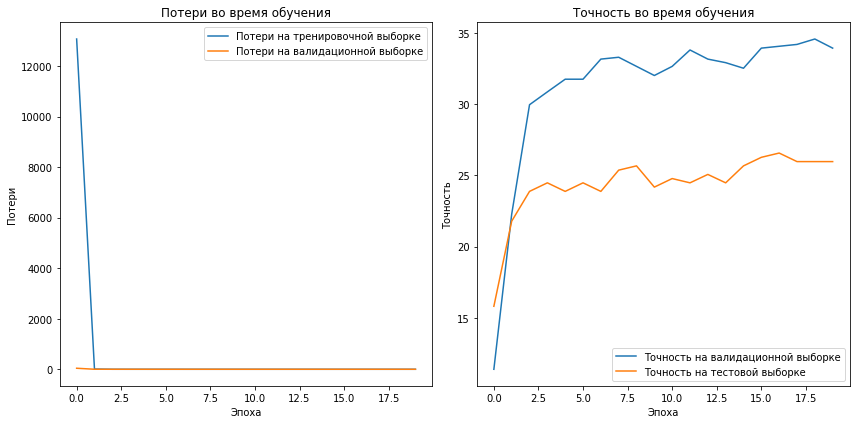

Метрики на тестовой выборке:  {'uar': 21.01927243374612, 'war': 21.071428571428573, 'mf1': 20.68541516113194, 'wf1': 20.63153526292291}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=32, num_layers=4, lr=0.0001, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


Тестирование 20: 100%|██████████| 11/11 [00:06<00:00,  1.71batch/s, Точность=35.2, Средняя потеря=2.35]


Ранняя остановка на эпохе 20 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 36.42, модель = 'Mamba_jina_emb_10_36.42_checkpoint.pth'


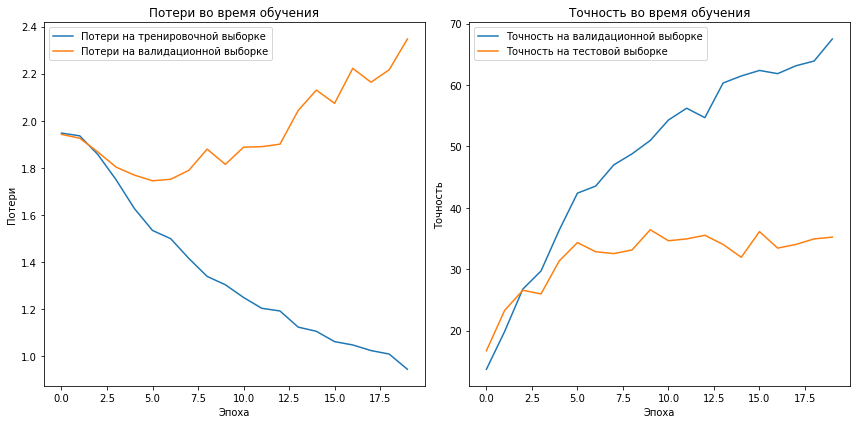

Метрики на тестовой выборке:  {'uar': 30.863208132944976, 'war': 31.785714285714285, 'mf1': 29.987253676425762, 'wf1': 30.546979482265662}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=128, num_layers=10, lr=0.0001, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.0001
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 20: 100%|██████████| 11/11 [00:06<00:00,  1.70batch/s, Точность=26.3, Средняя потеря=1.82]


Максимальная точность на валидационной выборке = 26.27, модель = 'Mamba_jina_emb_14_26.27_checkpoint.pth'


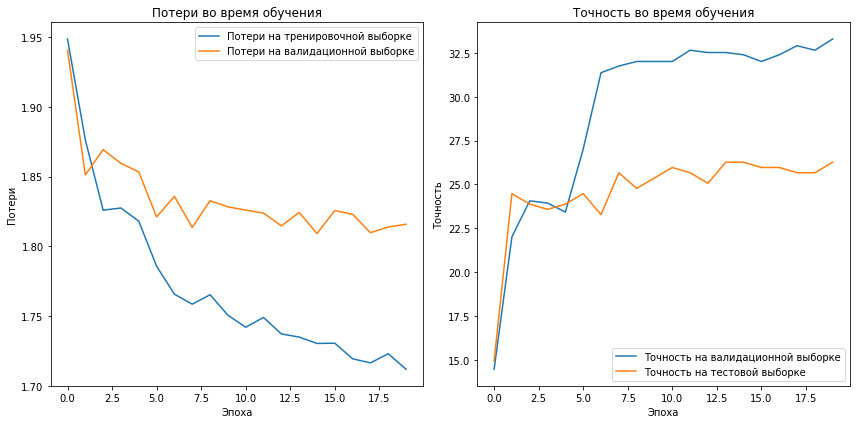

Метрики на тестовой выборке:  {'uar': 22.86884286884287, 'war': 24.642857142857146, 'mf1': 18.12826435346972, 'wf1': 19.405941155840978}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=128, num_layers=1, lr=0.001, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Тестирование 17: 100%|██████████| 11/11 [00:06<00:00,  1.72batch/s, Точность=35.8, Средняя потеря=3.59]


Ранняя остановка на эпохе 17 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 40.6, модель = 'Mamba_jina_emb_7_40.6_checkpoint.pth'


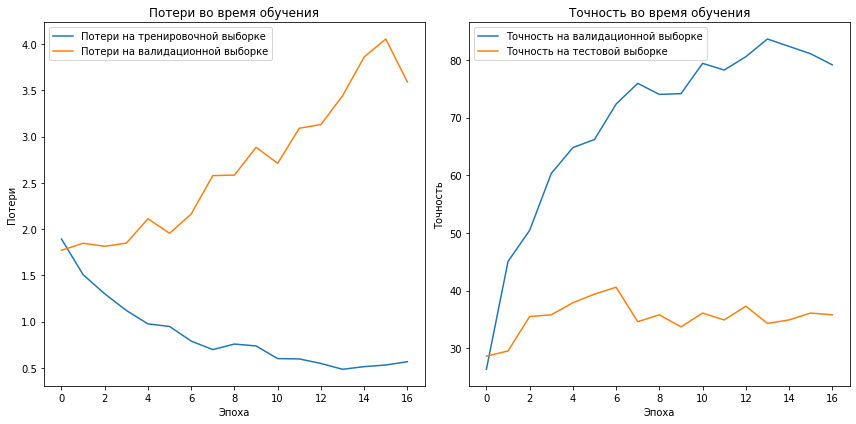

Метрики на тестовой выборке:  {'uar': 36.42513198434251, 'war': 37.142857142857146, 'mf1': 36.03078791670074, 'wf1': 36.50056238632444}


In [15]:
for it in range(N_ITER):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina_emb', num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    print(f"Параметры: d_model={d_model}, num_layers={num_layers}, lr={lr}, optimizer={optimizer}")
    loss_fn = nn.CrossEntropyLoss()
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics])

In [16]:
df = pd.DataFrame(result, columns=["параметры", "метрики"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики"].apply(pd.Series)], axis=1)
df

,d_model,num_layers,lr,optimizer,uar,war,mf1,wf1
0,32,1,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,33.627798,34.642857,33.214259,34.098712
1,32,4,0.0010,RMSprop (\nParameter Group 0\n alpha: 0.99\...,28.531634,29.642857,26.603556,27.309631
2,256,1,0.0010,RMSprop (\nParameter Group 0\n alpha: 0.99\...,29.594303,30.714286,25.998099,26.416740
3,128,10,0.0100,AdamW (\nParameter Group 0\n amsgrad: False...,18.135975,18.571429,17.436112,17.631733
4,512,1,0.0010,Rprop (\nParameter Group 0\n capturable: Fa...,36.760527,37.857143,36.030061,36.569639
5,512,10,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,18.975864,19.642857,16.270803,16.917206
6,256,8,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,18.429345,16.785714,14.367742,13.528154
7,32,10,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,19.090719,20.000000,14.060610,14.834318
8,64,4,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,26.334222,27.142857,25.946470,26.331252
9,128,1,0.0010,AdamW (\nParameter Group 0\n amsgrad: False...,36.718943,36.785714,35.858457,36.128406


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Ранняя остановка на эпохе 16 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 37.61, модель = 'Mamba_jina_emb_11_37.61_checkpoint.pth'


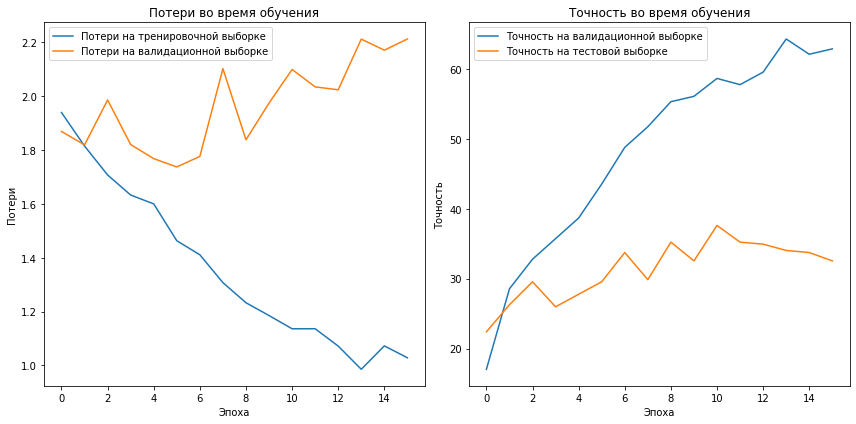

In [17]:
model_mamba = Mamba(model_name='jina_emb', num_layers = 6, d_input = 1024, d_model = 256, num_classes=7).to(device)
optimizer = optim.AdamW(params = model_mamba.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn)
trainer.train(PATH_TO_MODEL)

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=1, lr=0.01, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.01
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 19: 100%|██████████| 11/11 [00:01<00:00,  5.74batch/s, Точность=34.6, Средняя потеря=2.45]


Ранняя остановка на эпохе 19 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 35.22, модель = 'Mamba_jina_9_35.22_checkpoint.pth'


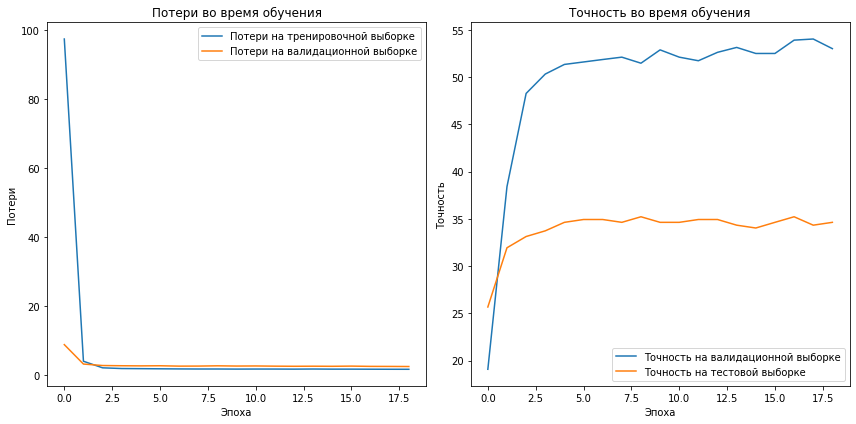

Метрики на тестовой выборке:  {'uar': 30.099179408389936, 'war': 30.357142857142854, 'mf1': 30.040836040392342, 'wf1': 30.487317254820418}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=2, lr=0.001, optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


Тестирование 20: 100%|██████████| 11/11 [00:01<00:00,  6.21batch/s, Точность=34.6, Средняя потеря=2.94]


Ранняя остановка на эпохе 20 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 37.91, модель = 'Mamba_jina_10_37.91_checkpoint.pth'


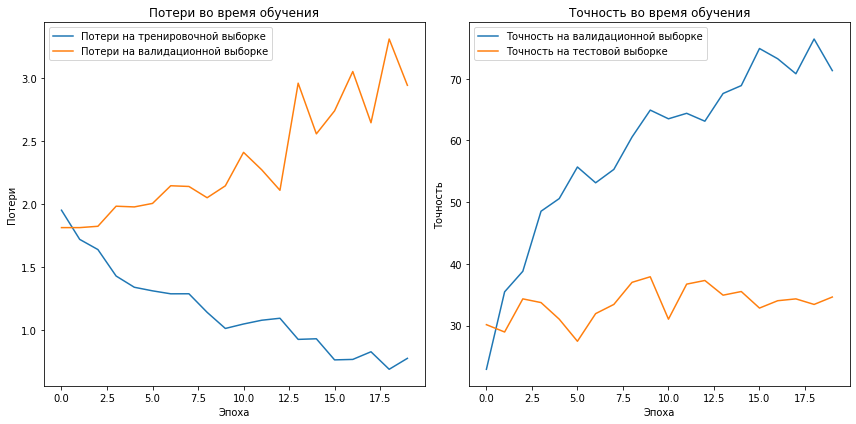

Метрики на тестовой выборке:  {'uar': 33.33307162254531, 'war': 34.64285714285714, 'mf1': 32.61180254171679, 'wf1': 33.68419792295981}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=10, lr=0.001, optimizer=RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)


Тестирование 12: 100%|██████████| 11/11 [00:01<00:00,  6.28batch/s, Точность=16.1, Средняя потеря=2.41e+5]


Ранняя остановка на эпохе 12 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 17.01, модель = 'Mamba_jina_2_17.01_checkpoint.pth'


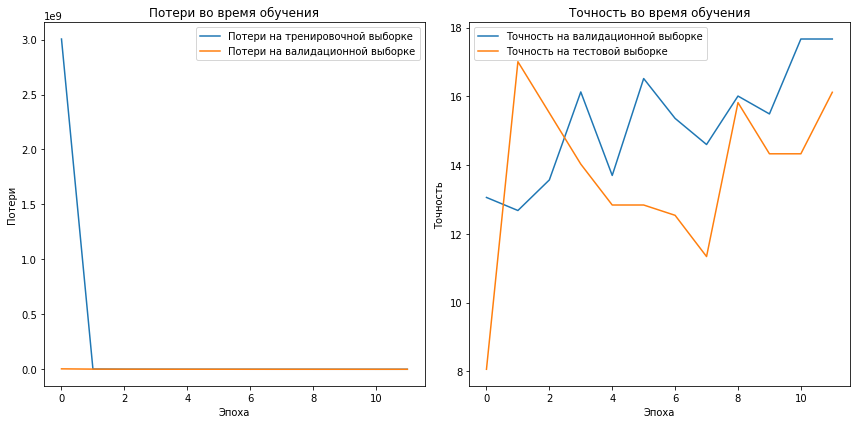

Метрики на тестовой выборке:  {'uar': 11.652046783625732, 'war': 11.428571428571429, 'mf1': 5.961851696258134, 'wf1': 5.880530435359409}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=2, lr=0.01, optimizer=RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


Тестирование 27: 100%|██████████| 11/11 [00:01<00:00,  6.36batch/s, Точность=37.3, Средняя потеря=3.49]


Ранняя остановка на эпохе 27 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 39.1, модель = 'Mamba_jina_17_39.1_checkpoint.pth'


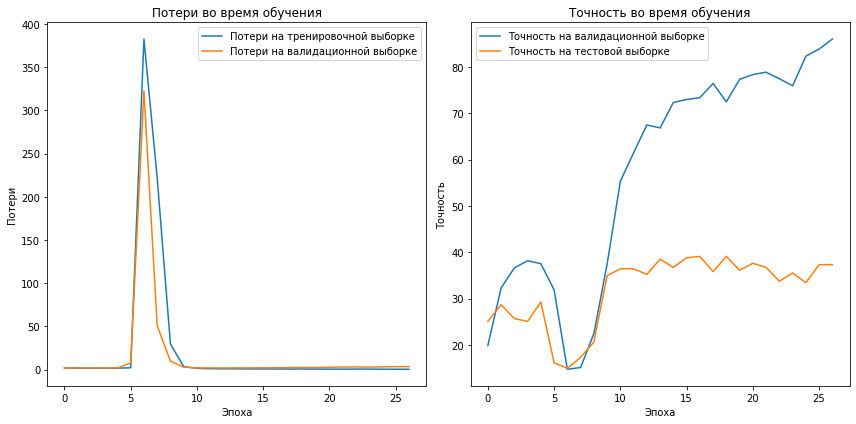

Метрики на тестовой выборке:  {'uar': 35.29043482990852, 'war': 36.07142857142857, 'mf1': 34.395989465505856, 'wf1': 35.090625686315974}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=32, num_layers=1, lr=0.001, optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


Тестирование 27: 100%|██████████| 11/11 [00:01<00:00,  6.43batch/s, Точность=37.6, Средняя потеря=5.2]


Ранняя остановка на эпохе 27 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 38.21, модель = 'Mamba_jina_17_38.21_checkpoint.pth'


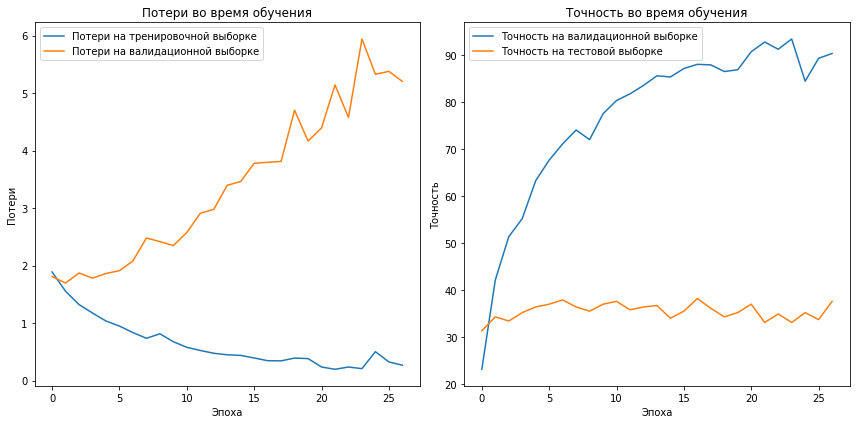

Метрики на тестовой выборке:  {'uar': 33.74868631447579, 'war': 35.0, 'mf1': 32.420650728818195, 'wf1': 33.2121978913331}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=8, lr=0.01, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.01
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 15: 100%|██████████| 11/11 [00:01<00:00,  6.19batch/s, Точность=19.1, Средняя потеря=49.5]


Ранняя остановка на эпохе 15 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 20.0, модель = 'Mamba_jina_5_20.0_checkpoint.pth'


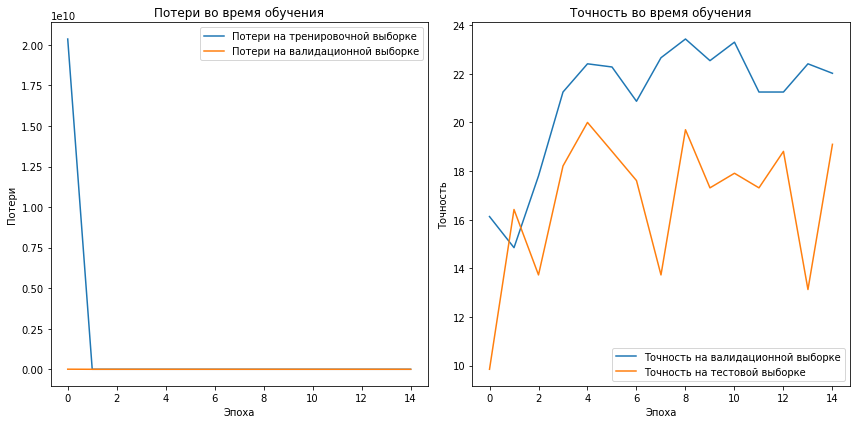

Метрики на тестовой выборке:  {'uar': 19.84962919173445, 'war': 20.714285714285715, 'mf1': 19.514294975208962, 'wf1': 20.269839381559095}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=8, lr=0.0001, optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)


Тестирование 27: 100%|██████████| 11/11 [00:01<00:00,  6.36batch/s, Точность=24.8, Средняя потеря=2.27]


Ранняя остановка на эпохе 27 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 31.64, модель = 'Mamba_jina_17_31.64_checkpoint.pth'


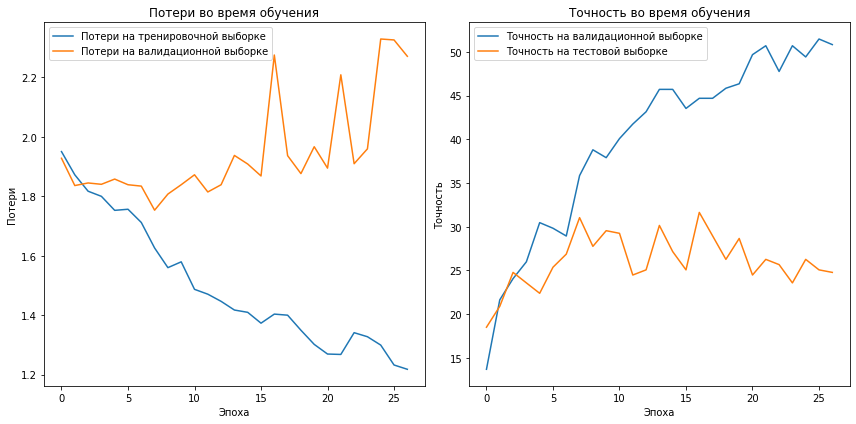

Метрики на тестовой выборке:  {'uar': 26.679798390324706, 'war': 27.500000000000004, 'mf1': 24.58052866137664, 'wf1': 25.17340875212941}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=32, num_layers=10, lr=0.01, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


Тестирование 18: 100%|██████████| 11/11 [00:01<00:00,  6.17batch/s, Точность=16.4, Средняя потеря=4.69e+16]


Ранняя остановка на эпохе 18 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 18.51, модель = 'Mamba_jina_8_18.51_checkpoint.pth'


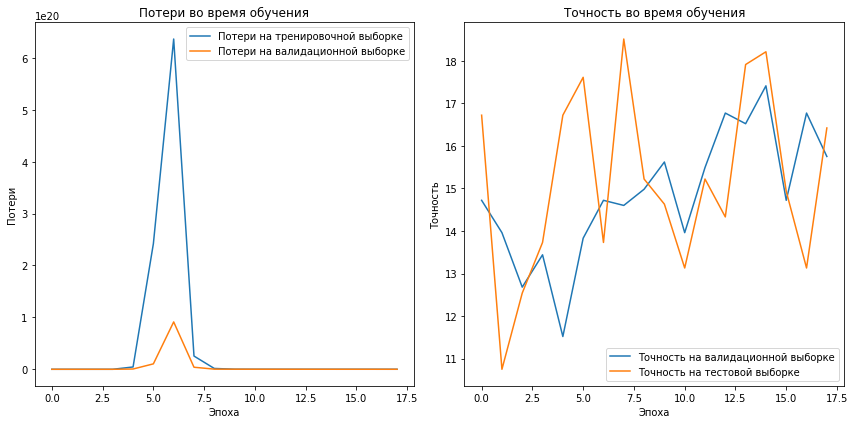

Метрики на тестовой выборке:  {'uar': 16.65954915954916, 'war': 17.5, 'mf1': 10.631725417439704, 'wf1': 11.292949907235622}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=8, lr=0.001, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.001
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 13: 100%|██████████| 11/11 [00:01<00:00,  6.28batch/s, Точность=25.4, Средняя потеря=1.84]


Ранняя остановка на эпохе 13 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 26.87, модель = 'Mamba_jina_3_26.87_checkpoint.pth'


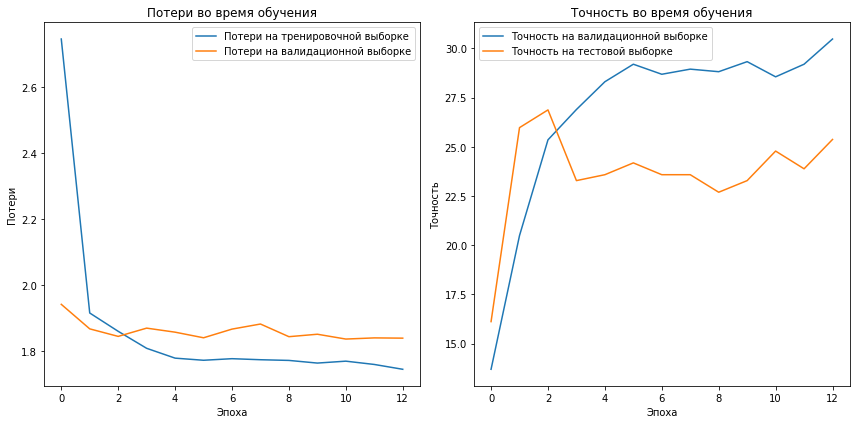

Метрики на тестовой выборке:  {'uar': 19.159549159549158, 'war': 21.071428571428573, 'mf1': 12.281182546551864, 'wf1': 13.456698364883685}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=512, num_layers=6, lr=0.01, optimizer=RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


Тестирование 23: 100%|██████████| 11/11 [00:01<00:00,  6.17batch/s, Точность=17.9, Средняя потеря=4.82e+7]


Ранняя остановка на эпохе 23 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 19.4, модель = 'Mamba_jina_13_19.4_checkpoint.pth'


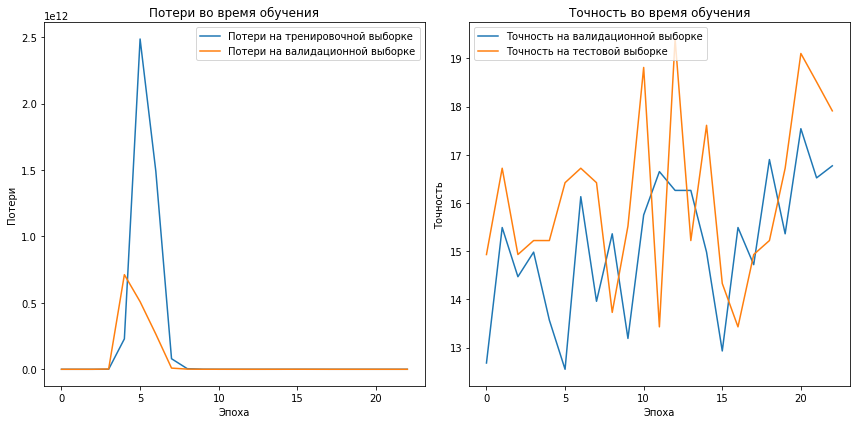

Метрики на тестовой выборке:  {'uar': 15.627183489025592, 'war': 16.071428571428573, 'mf1': 11.610174531209376, 'wf1': 11.834385816259509}


In [14]:
result = []
for it in range(N_ITER):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina', pooling=None, num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    print(f"Параметры: d_model={d_model}, num_layers={num_layers}, lr={lr}, optimizer={optimizer}")
    loss_fn = nn.CrossEntropyLoss()
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics, trainer._best_model_name])

In [15]:
df = pd.DataFrame(result, columns=["параметры", "метрики", "путь"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики"].apply(pd.Series), df["путь"]], axis=1)
df

,d_model,num_layers,lr,optimizer,uar,war,mf1,wf1,путь
0,256,1,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,30.099179,30.357143,30.040836,30.487317,Mamba_jina_9_35.22_checkpoint.pth
1,256,2,0.0010,AdamW (\nParameter Group 0\n amsgrad: False...,33.333072,34.642857,32.611803,33.684198,Mamba_jina_10_37.91_checkpoint.pth
2,64,10,0.0010,RMSprop (\nParameter Group 0\n alpha: 0.99\...,11.652047,11.428571,5.961852,5.880530,Mamba_jina_2_17.01_checkpoint.pth
3,256,2,0.0100,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",35.290435,36.071429,34.395989,35.090626,Mamba_jina_17_39.1_checkpoint.pth
4,32,1,0.0010,AdamW (\nParameter Group 0\n amsgrad: False...,33.748686,35.000000,32.420651,33.212198,Mamba_jina_17_38.21_checkpoint.pth
5,64,8,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,19.849629,20.714286,19.514295,20.269839,Mamba_jina_5_20.0_checkpoint.pth
6,256,8,0.0001,AdamW (\nParameter Group 0\n amsgrad: False...,26.679798,27.500000,24.580529,25.173409,Mamba_jina_17_31.64_checkpoint.pth
7,32,10,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,16.659549,17.500000,10.631725,11.292950,Mamba_jina_8_18.51_checkpoint.pth
8,64,8,0.0010,Rprop (\nParameter Group 0\n capturable: Fa...,19.159549,21.071429,12.281183,13.456698,Mamba_jina_3_26.87_checkpoint.pth
9,512,6,0.0100,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",15.627183,16.071429,11.610175,11.834386,Mamba_jina_13_19.4_checkpoint.pth


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=4, lr=0.0001, optimizer=RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0
    weight_decay: 0
)


Тестирование 15: 100%|██████████| 11/11 [00:01<00:00,  6.20batch/s, Точность=34.6, Средняя потеря=2.23]


Ранняя остановка на эпохе 15 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 37.31, модель = 'Mamba_jina_5_37.31_checkpoint.pth'


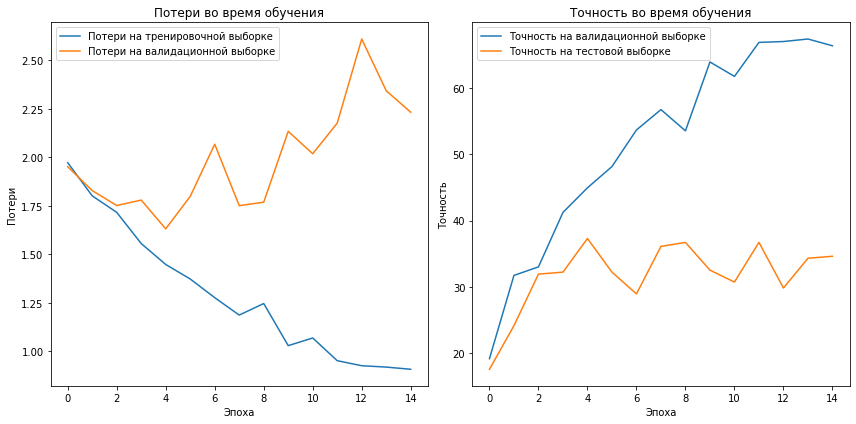

Метрики на тестовой выборке:  {'uar': 35.02303183224236, 'war': 35.35714285714286, 'mf1': 31.8751136169174, 'wf1': 32.46899212073192}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=128, num_layers=6, lr=0.01, optimizer=RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)


Тестирование 24: 100%|██████████| 11/11 [00:01<00:00,  6.14batch/s, Точность=17.3, Средняя потеря=2.36e+20]


Ранняя остановка на эпохе 24 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 18.81, модель = 'Mamba_jina_14_18.81_checkpoint.pth'


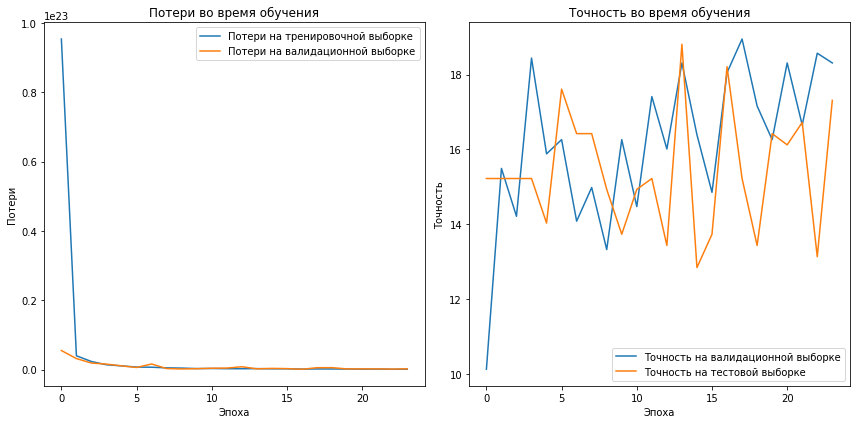

Метрики на тестовой выборке:  {'uar': 11.142391964760385, 'war': 11.428571428571429, 'mf1': 8.032295562237115, 'wf1': 7.987933902229198}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=1, lr=0.0001, optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)


Тестирование 18: 100%|██████████| 11/11 [00:01<00:00,  6.13batch/s, Точность=36.7, Средняя потеря=1.84]


Ранняя остановка на эпохе 18 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 40.0, модель = 'Mamba_jina_8_40.0_checkpoint.pth'


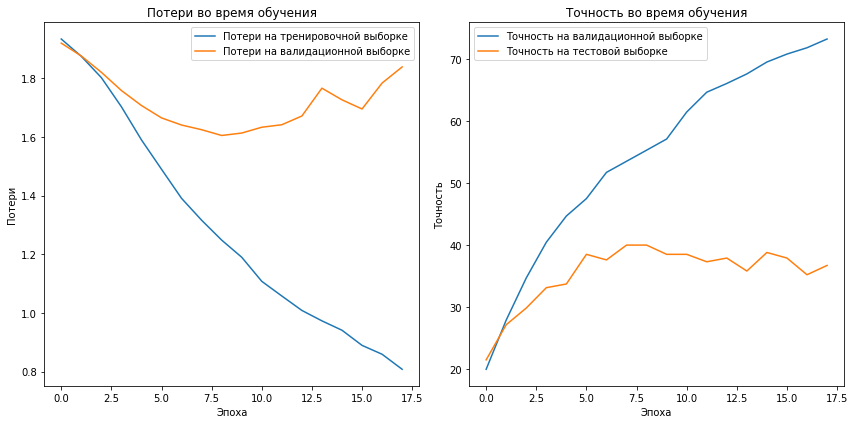

Метрики на тестовой выборке:  {'uar': 32.46546187335661, 'war': 33.57142857142857, 'mf1': 31.981592645389835, 'wf1': 32.721938376992135}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=128, num_layers=10, lr=0.01, optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)


Тестирование 35: 100%|██████████| 11/11 [00:01<00:00,  6.31batch/s, Точность=16.7, Средняя потеря=2.73e+15]


Ранняя остановка на эпохе 35 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 19.1, модель = 'Mamba_jina_25_19.1_checkpoint.pth'


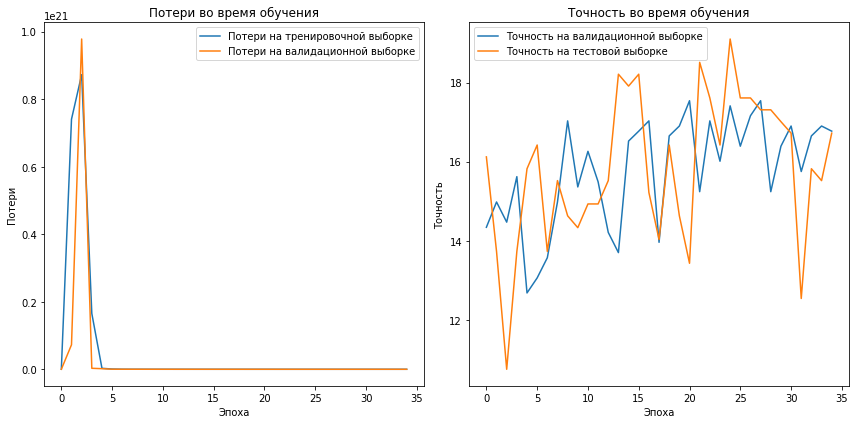

Метрики на тестовой выборке:  {'uar': 19.462017554122816, 'war': 20.0, 'mf1': 18.291189282441543, 'wf1': 18.660268269639133}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=32, num_layers=2, lr=0.01, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


Тестирование 15: 100%|██████████| 11/11 [00:01<00:00,  6.26batch/s, Точность=31.3, Средняя потеря=3.14]


Ранняя остановка на эпохе 15 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 35.22, модель = 'Mamba_jina_5_35.22_checkpoint.pth'


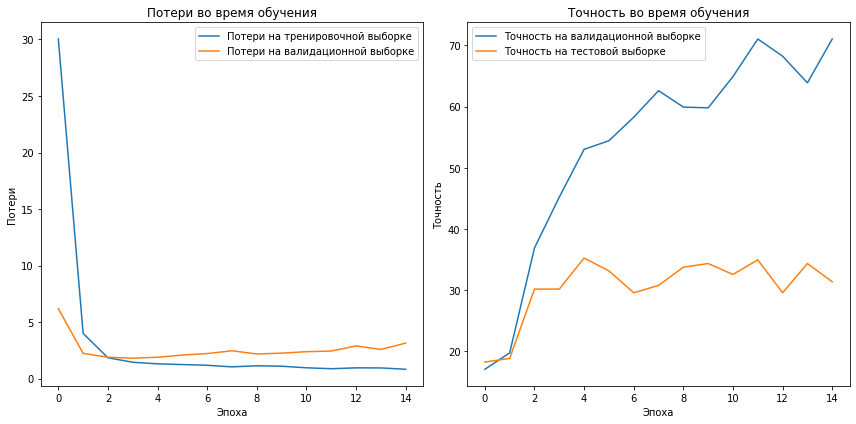

Метрики на тестовой выборке:  {'uar': 36.40447864132074, 'war': 36.42857142857142, 'mf1': 36.07198191166992, 'wf1': 35.962983038986856}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=128, num_layers=6, lr=0.0001, optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)


Тестирование 47: 100%|██████████| 11/11 [00:01<00:00,  6.37batch/s, Точность=32.5, Средняя потеря=3.15]


Ранняя остановка на эпохе 47 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 33.43, модель = 'Mamba_jina_37_33.43_checkpoint.pth'


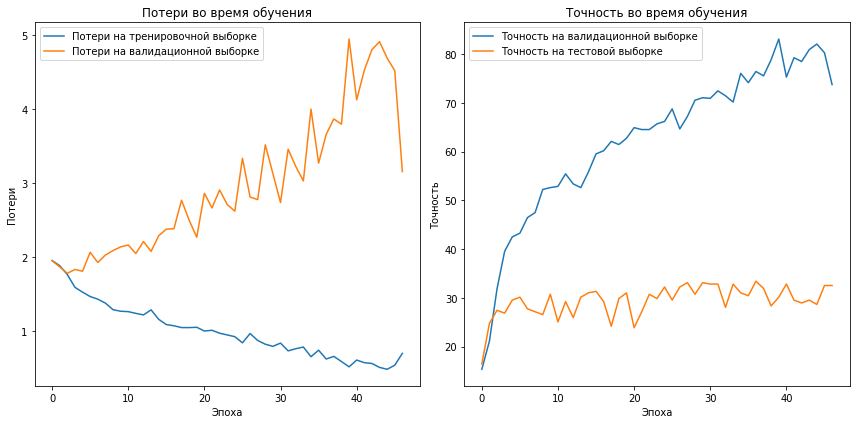

Метрики на тестовой выборке:  {'uar': 29.158010967221493, 'war': 29.28571428571429, 'mf1': 29.24391038898197, 'wf1': 29.268964873622927}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=2, lr=0.0001, optimizer=RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


Тестирование 25: 100%|██████████| 11/11 [00:01<00:00,  6.32batch/s, Точность=37.3, Средняя потеря=2.65]


Ранняя остановка на эпохе 25 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 38.51, модель = 'Mamba_jina_15_38.51_checkpoint.pth'


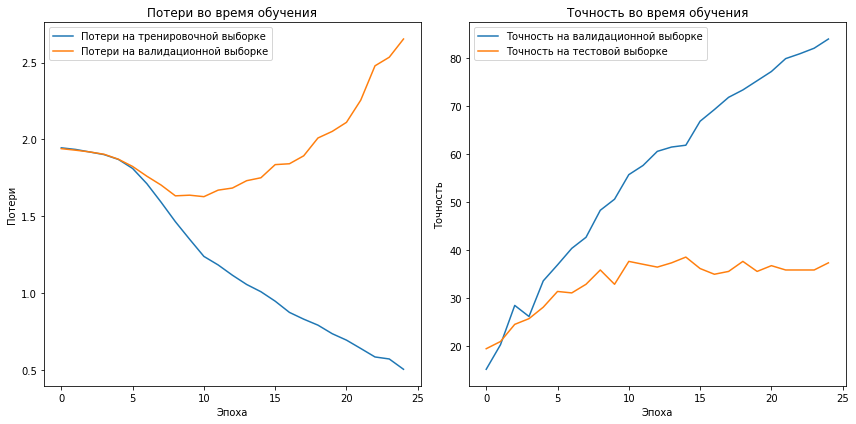

Метрики на тестовой выборке:  {'uar': 34.16972252498569, 'war': 35.35714285714286, 'mf1': 32.819702326532415, 'wf1': 33.86216710664982}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=1, lr=0.001, optimizer=RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Тестирование 15: 100%|██████████| 11/11 [00:01<00:00,  6.34batch/s, Точность=34.6, Средняя потеря=2.85]


Ранняя остановка на эпохе 15 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 39.1, модель = 'Mamba_jina_5_39.1_checkpoint.pth'


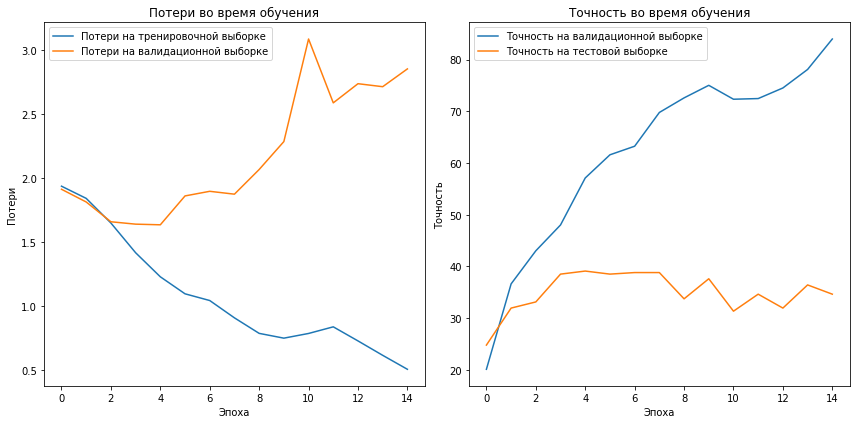

Метрики на тестовой выборке:  {'uar': 35.16920628762734, 'war': 36.07142857142857, 'mf1': 34.04757524734298, 'wf1': 34.696858134748794}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=512, num_layers=4, lr=0.001, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.001
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 20: 100%|██████████| 11/11 [00:01<00:00,  6.19batch/s, Точность=32.8, Средняя потеря=1.74]


Ранняя остановка на эпохе 20 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 33.43, модель = 'Mamba_jina_10_33.43_checkpoint.pth'


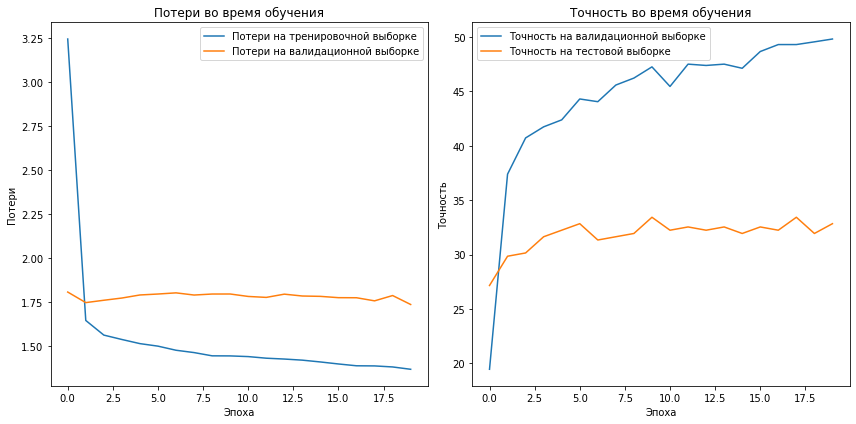

Метрики на тестовой выборке:  {'uar': 30.177117907381074, 'war': 31.071428571428573, 'mf1': 29.633047944642982, 'wf1': 30.31956609097114}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=8, lr=0.0001, optimizer=RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0
    weight_decay: 0
)


Тестирование 22: 100%|██████████| 11/11 [00:01<00:00,  6.22batch/s, Точность=23, Средняя потеря=2]


Ранняя остановка на эпохе 22 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 26.87, модель = 'Mamba_jina_12_26.87_checkpoint.pth'


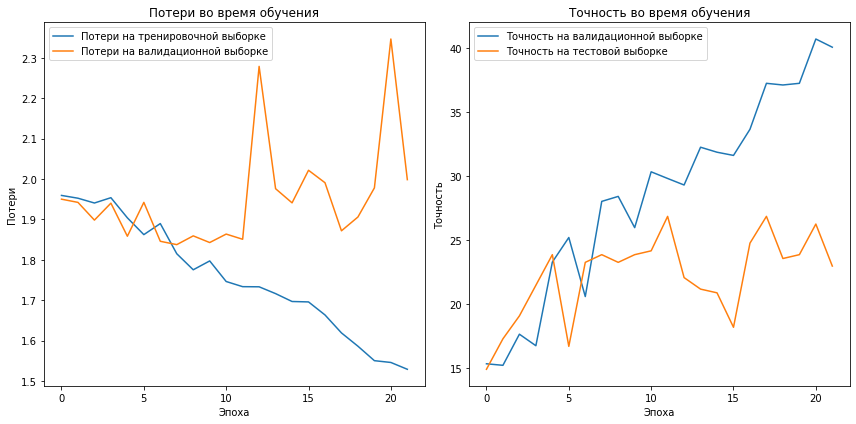

Метрики на тестовой выборке:  {'uar': 21.869076869076867, 'war': 23.92857142857143, 'mf1': 16.84453550845139, 'wf1': 18.466245994738586}


In [16]:
for it in range(N_ITER):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina', pooling=None, num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    print(f"Параметры: d_model={d_model}, num_layers={num_layers}, lr={lr}, optimizer={optimizer}")
    loss_fn = nn.CrossEntropyLoss()
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics, trainer._best_model_name])

In [17]:
df = pd.DataFrame(result, columns=["параметры", "метрики", "путь"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики"].apply(pd.Series), df["путь"]], axis=1)
df

,d_model,num_layers,lr,optimizer,uar,war,mf1,wf1,путь
0,256,1,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,30.099179,30.357143,30.040836,30.487317,Mamba_jina_9_35.22_checkpoint.pth
1,256,2,0.0010,AdamW (\nParameter Group 0\n amsgrad: False...,33.333072,34.642857,32.611803,33.684198,Mamba_jina_10_37.91_checkpoint.pth
2,64,10,0.0010,RMSprop (\nParameter Group 0\n alpha: 0.99\...,11.652047,11.428571,5.961852,5.880530,Mamba_jina_2_17.01_checkpoint.pth
3,256,2,0.0100,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",35.290435,36.071429,34.395989,35.090626,Mamba_jina_17_39.1_checkpoint.pth
4,32,1,0.0010,AdamW (\nParameter Group 0\n amsgrad: False...,33.748686,35.000000,32.420651,33.212198,Mamba_jina_17_38.21_checkpoint.pth
5,64,8,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,19.849629,20.714286,19.514295,20.269839,Mamba_jina_5_20.0_checkpoint.pth
6,256,8,0.0001,AdamW (\nParameter Group 0\n amsgrad: False...,26.679798,27.500000,24.580529,25.173409,Mamba_jina_17_31.64_checkpoint.pth
7,32,10,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,16.659549,17.500000,10.631725,11.292950,Mamba_jina_8_18.51_checkpoint.pth
8,64,8,0.0010,Rprop (\nParameter Group 0\n capturable: Fa...,19.159549,21.071429,12.281183,13.456698,Mamba_jina_3_26.87_checkpoint.pth
9,512,6,0.0100,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",15.627183,16.071429,11.610175,11.834386,Mamba_jina_13_19.4_checkpoint.pth


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=512, num_layers=6, lr=0.01, optimizer=Rprop (
Parameter Group 0
    capturable: False
    differentiable: False
    etas: (0.5, 1.2)
    foreach: None
    lr: 0.01
    maximize: False
    step_sizes: (1e-06, 50)
)


Тестирование 11: 100%|██████████| 11/11 [00:01<00:00,  6.06batch/s, Точность=18.8, Средняя потеря=3.15e+7]


Ранняя остановка на эпохе 11 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 19.7, модель = 'Mamba_jina_1_19.7_checkpoint.pth'


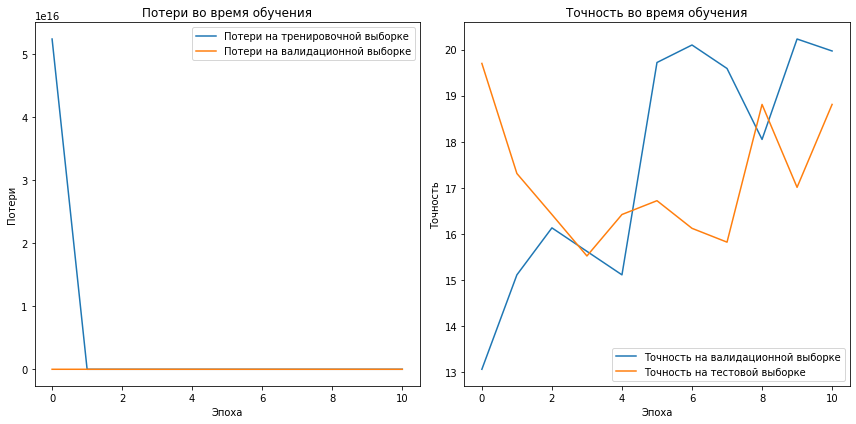

Метрики на тестовой выборке:  {'uar': 16.616256550467075, 'war': 14.642857142857144, 'mf1': 10.095397556285155, 'wf1': 9.638936227312477}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=64, num_layers=6, lr=0.0001, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


Тестирование 25: 100%|██████████| 11/11 [00:01<00:00,  6.12batch/s, Точность=30.4, Средняя потеря=2.72]


Ранняя остановка на эпохе 25 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 31.94, модель = 'Mamba_jina_15_31.94_checkpoint.pth'


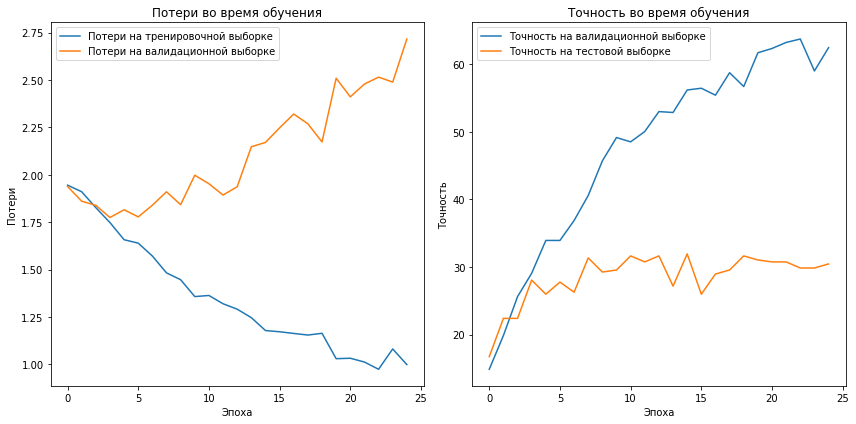

Метрики на тестовой выборке:  {'uar': 26.751927936138465, 'war': 27.500000000000004, 'mf1': 25.968734113507004, 'wf1': 26.643675090902637}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=256, num_layers=2, lr=0.001, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Тестирование 29: 100%|██████████| 11/11 [00:01<00:00,  6.19batch/s, Точность=33.7, Средняя потеря=3.93]


Ранняя остановка на эпохе 29 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 37.61, модель = 'Mamba_jina_19_37.61_checkpoint.pth'


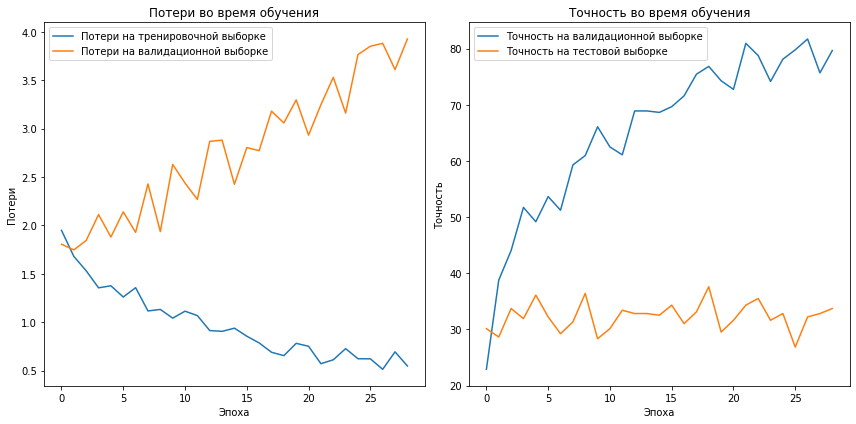

Метрики на тестовой выборке:  {'uar': 33.31659795475585, 'war': 34.285714285714285, 'mf1': 33.292014841649106, 'wf1': 33.95007340830114}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=32, num_layers=6, lr=0.01, optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)


Тестирование 15: 100%|██████████| 11/11 [00:01<00:00,  6.39batch/s, Точность=22.7, Средняя потеря=2.71]


Ранняя остановка на эпохе 15 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 28.66, модель = 'Mamba_jina_5_28.66_checkpoint.pth'


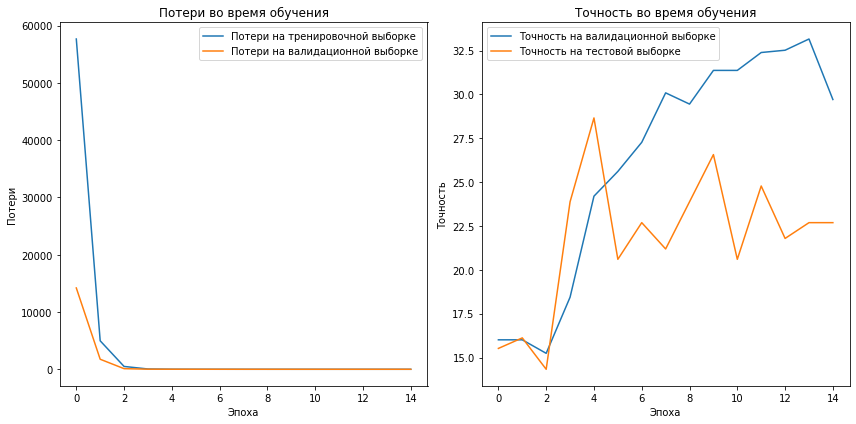

Метрики на тестовой выборке:  {'uar': 23.973058413847887, 'war': 25.0, 'mf1': 22.084840902708873, 'wf1': 22.65536063969366}


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Параметры: d_model=128, num_layers=4, lr=0.001, optimizer=RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)


Тестирование 19: 100%|██████████| 11/11 [00:02<00:00,  5.25batch/s, Точность=19.1, Средняя потеря=41.2]


Ранняя остановка на эпохе 19 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 19.1, модель = 'Mamba_jina_9_19.1_checkpoint.pth'


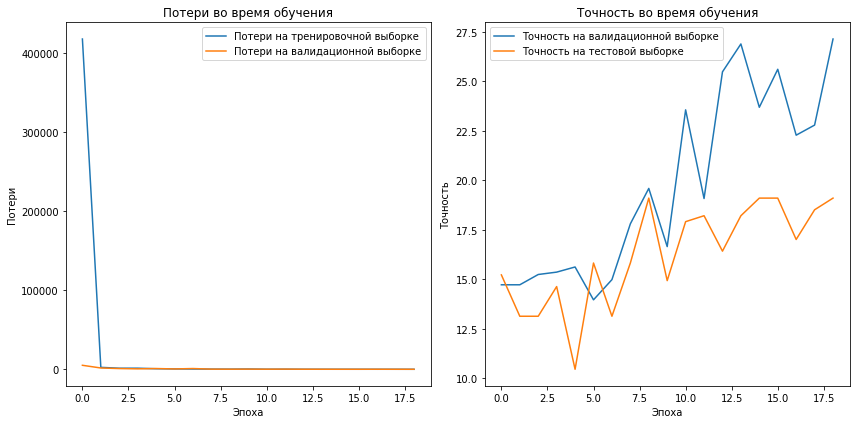

Метрики на тестовой выборке:  {'uar': 18.60376396560607, 'war': 18.571428571428573, 'mf1': 18.307476711803957, 'wf1': 18.277654031541793}


In [18]:
for it in range(5):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina', pooling=None, num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    print(f"Параметры: d_model={d_model}, num_layers={num_layers}, lr={lr}, optimizer={optimizer}")
    loss_fn = nn.CrossEntropyLoss()
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics, trainer._best_model_name])

In [19]:
df = pd.DataFrame(result, columns=["параметры", "метрики", "путь"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики"].apply(pd.Series), df["путь"]], axis=1)
df

,d_model,num_layers,lr,optimizer,uar,war,mf1,wf1,путь
0,256,1,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,30.099179,30.357143,30.040836,30.487317,Mamba_jina_9_35.22_checkpoint.pth
1,256,2,0.0010,AdamW (\nParameter Group 0\n amsgrad: False...,33.333072,34.642857,32.611803,33.684198,Mamba_jina_10_37.91_checkpoint.pth
2,64,10,0.0010,RMSprop (\nParameter Group 0\n alpha: 0.99\...,11.652047,11.428571,5.961852,5.880530,Mamba_jina_2_17.01_checkpoint.pth
3,256,2,0.0100,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",35.290435,36.071429,34.395989,35.090626,Mamba_jina_17_39.1_checkpoint.pth
4,32,1,0.0010,AdamW (\nParameter Group 0\n amsgrad: False...,33.748686,35.000000,32.420651,33.212198,Mamba_jina_17_38.21_checkpoint.pth
5,64,8,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,19.849629,20.714286,19.514295,20.269839,Mamba_jina_5_20.0_checkpoint.pth
6,256,8,0.0001,AdamW (\nParameter Group 0\n amsgrad: False...,26.679798,27.500000,24.580529,25.173409,Mamba_jina_17_31.64_checkpoint.pth
7,32,10,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,16.659549,17.500000,10.631725,11.292950,Mamba_jina_8_18.51_checkpoint.pth
8,64,8,0.0010,Rprop (\nParameter Group 0\n capturable: Fa...,19.159549,21.071429,12.281183,13.456698,Mamba_jina_3_26.87_checkpoint.pth
9,512,6,0.0100,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",15.627183,16.071429,11.610175,11.834386,Mamba_jina_13_19.4_checkpoint.pth


In [16]:
%%capture --no-stdout
result = []
for it in range(N_ITER):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina', pooling=None, num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss()
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics, trainer._best_model_name])

Ранняя остановка на эпохе 17 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 22.39, модель = 'Mamba_jina_7_22.39_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 18.7012987012987, 'war': 20.714285714285715, 'mf1': 12.058472022383967, 'wf1': 13.34224130254444}
Ранняя остановка на эпохе 29 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 35.22, модель = 'Mamba_jina_19_35.22_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 33.340650972229916, 'war': 34.285714285714285, 'mf1': 32.381042340365596, 'wf1': 33.29378408939838}
Ранняя остановка на эпохе 18 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 37.61, модель = 'Mamba_jina_8_37.61_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 29.63985260037892, 'war': 30.0, 'mf1': 29.55294605755651, 'wf1': 29.90382094633876}


In [ ]:
df = pd.DataFrame(result, columns=["параметры", "метрики", "путь"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики"].apply(pd.Series), df["путь"]], axis=1)
df

,d_model,num_layers,lr,optimizer,uar,war,mf1,wf1,путь
0,32,10,0.0010,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",18.701299,20.714286,12.058472,13.342241,Mamba_jina_7_22.39_checkpoint.pth
1,256,6,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,33.340651,34.285714,32.381042,33.293784,Mamba_jina_19_35.22_checkpoint.pth
2,512,10,0.0001,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",29.515963,31.071429,26.991059,28.279644,Mamba_jina_15_30.75_checkpoint.pth
3,256,2,0.0010,Adam (\nParameter Group 0\n amsgrad: False\...,34.633402,35.714286,34.009716,34.843076,Mamba_jina_12_38.51_checkpoint.pth
4,64,8,0.0001,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",29.474826,30.357143,29.307979,29.906414,Mamba_jina_26_33.13_checkpoint.pth
5,64,2,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,36.456560,36.785714,36.326798,36.497422,Mamba_jina_11_40.6_checkpoint.pth
6,64,4,0.0010,Adam (\nParameter Group 0\n amsgrad: False\...,32.146353,32.857143,31.850365,32.393010,Mamba_jina_14_35.52_checkpoint.pth
7,512,6,0.0001,AdamW (\nParameter Group 0\n amsgrad: False...,33.793833,34.285714,33.105220,33.329943,Mamba_jina_13_37.31_checkpoint.pth
8,32,2,0.0010,AdamW (\nParameter Group 0\n amsgrad: False...,33.266146,33.928571,32.840387,33.329301,Mamba_jina_7_37.91_checkpoint.pth
9,64,1,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,29.639853,30.000000,29.552946,29.903821,Mamba_jina_8_37.61_checkpoint.pth


In [14]:
result = []

In [15]:
%%capture --no-stdout
for it in range(N_ITER):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina', pooling=None, num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss()
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics, trainer._best_model_name])

Ранняя остановка на эпохе 36 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 24.48, модель = 'Mamba_jina_26_24.48_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 26.897214627477783, 'war': 28.214285714285715, 'mf1': 22.050538288694984, 'wf1': 22.951998409222693}
Ранняя остановка на эпохе 40 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 40.0, модель = 'Mamba_jina_30_40.0_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 37.97579406132038, 'war': 37.857142857142854, 'mf1': 37.58281467210039, 'wf1': 37.65766359962788}
Ранняя остановка на эпохе 12 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 23.28, модель = 'Mamba_jina_2_23.28_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 18.064065004854477, 'war': 18.571428571428573, 'mf1': 16.806930243527354, 'wf1': 17.17638045326649}
Ранняя остановка на эпохе 49 

In [16]:
df = pd.DataFrame(result, columns=["параметры", "метрики", "путь"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики"].apply(pd.Series), df["путь"]], axis=1)
df

,d_model,num_layers,lr,optimizer,uar,war,mf1,wf1,путь
0,32,10,0.0001,Rprop (\nParameter Group 0\n capturable: Fa...,26.897215,28.214286,22.050538,22.951998,Mamba_jina_26_24.48_checkpoint.pth
1,256,2,0.0100,AdamW (\nParameter Group 0\n amsgrad: False...,37.975794,37.857143,37.582815,37.657664,Mamba_jina_30_40.0_checkpoint.pth
2,64,6,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,18.064065,18.571429,16.806930,17.176380,Mamba_jina_2_23.28_checkpoint.pth
3,256,2,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,33.296187,33.571429,32.917585,33.062195,Mamba_jina_39_39.4_checkpoint.pth
4,256,8,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,17.975718,19.642857,14.758711,15.854123,Mamba_jina_8_17.91_checkpoint.pth
5,512,1,0.0100,RMSprop (\nParameter Group 0\n alpha: 0.99\...,30.888743,30.714286,29.655966,29.579869,Mamba_jina_20_33.43_checkpoint.pth
6,128,1,0.0001,AdamW (\nParameter Group 0\n amsgrad: False...,36.163063,36.428571,36.122661,36.193036,Mamba_jina_14_40.9_checkpoint.pth
7,32,6,0.0010,Adam (\nParameter Group 0\n amsgrad: False\...,25.755800,27.500000,19.683924,20.819973,Mamba_jina_5_25.67_checkpoint.pth
8,512,6,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,18.227228,18.928571,14.519860,14.817615,Mamba_jina_27_22.39_checkpoint.pth
9,512,8,0.0001,AdamW (\nParameter Group 0\n amsgrad: False...,25.429738,26.785714,23.309010,24.259742,Mamba_jina_16_30.45_checkpoint.pth


In [18]:
%%capture --no-stdout
for it in range(N_ITER):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina', pooling=None, num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss()
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics, trainer._best_model_name])

Ранняя остановка на эпохе 11 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 16.72, модель = 'Mamba_jina_1_16.72_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 14.285714285714285, 'war': 15.714285714285714, 'mf1': 3.880070546737213, 'wf1': 4.268077601410935}
Ранняя остановка на эпохе 12 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 17.01, модель = 'Mamba_jina_2_17.01_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 12.972582972582972, 'war': 14.285714285714285, 'mf1': 4.454810495626822, 'wf1': 4.919339164237123}
Ранняя остановка на эпохе 13 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 37.91, модель = 'Mamba_jina_3_37.91_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 35.35921473421473, 'war': 36.07142857142857, 'mf1': 34.01295884571164, 'wf1': 34.6574151252364}
Ранняя остановка на эпохе 36 из-за

In [19]:
df = pd.DataFrame(result, columns=["параметры", "метрики", "путь"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики"].apply(pd.Series), df["путь"]], axis=1)
df

,d_model,num_layers,lr,optimizer,uar,war,mf1,wf1,путь
0,32,10,0.0001,Rprop (\nParameter Group 0\n capturable: Fa...,26.897215,28.214286,22.050538,22.951998,Mamba_jina_26_24.48_checkpoint.pth
1,256,2,0.0100,AdamW (\nParameter Group 0\n amsgrad: False...,37.975794,37.857143,37.582815,37.657664,Mamba_jina_30_40.0_checkpoint.pth
2,64,6,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,18.064065,18.571429,16.806930,17.176380,Mamba_jina_2_23.28_checkpoint.pth
3,256,2,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,33.296187,33.571429,32.917585,33.062195,Mamba_jina_39_39.4_checkpoint.pth
4,256,8,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,17.975718,19.642857,14.758711,15.854123,Mamba_jina_8_17.91_checkpoint.pth
5,512,1,0.0100,RMSprop (\nParameter Group 0\n alpha: 0.99\...,30.888743,30.714286,29.655966,29.579869,Mamba_jina_20_33.43_checkpoint.pth
6,128,1,0.0001,AdamW (\nParameter Group 0\n amsgrad: False...,36.163063,36.428571,36.122661,36.193036,Mamba_jina_14_40.9_checkpoint.pth
7,32,6,0.0010,Adam (\nParameter Group 0\n amsgrad: False\...,25.755800,27.500000,19.683924,20.819973,Mamba_jina_5_25.67_checkpoint.pth
8,512,6,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,18.227228,18.928571,14.519860,14.817615,Mamba_jina_27_22.39_checkpoint.pth
9,512,8,0.0001,AdamW (\nParameter Group 0\n amsgrad: False...,25.429738,26.785714,23.309010,24.259742,Mamba_jina_16_30.45_checkpoint.pth


In [23]:
%%capture --no-stdout
for it in range(N_ITER):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina', pooling=None, num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss()
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics, trainer._best_model_name])

Ранняя остановка на эпохе 18 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 28.66, модель = 'Mamba_jina_8_28.66_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 27.33108492976914, 'war': 28.214285714285715, 'mf1': 26.04291737357571, 'wf1': 26.788583231139125}
Ранняя остановка на эпохе 35 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 35.52, модель = 'Mamba_jina_25_35.52_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 32.498311708838024, 'war': 32.857142857142854, 'mf1': 32.11163218059864, 'wf1': 32.608041022084066}
Ранняя остановка на эпохе 20 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 38.21, модель = 'Mamba_jina_10_38.21_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 35.07651833309729, 'war': 35.35714285714286, 'mf1': 34.29254503495944, 'wf1': 34.82339161616094}
Ранняя остановка на эпохе 19 и

In [24]:
df = pd.DataFrame(result, columns=["параметры", "метрики", "путь"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики"].apply(pd.Series), df["путь"]], axis=1)
df

,d_model,num_layers,lr,optimizer,uar,war,mf1,wf1,путь
0,32,10,0.0001,Rprop (\nParameter Group 0\n capturable: Fa...,26.897215,28.214286,22.050538,22.951998,Mamba_jina_26_24.48_checkpoint.pth
1,256,2,0.0100,AdamW (\nParameter Group 0\n amsgrad: False...,37.975794,37.857143,37.582815,37.657664,Mamba_jina_30_40.0_checkpoint.pth
2,64,6,0.0100,Rprop (\nParameter Group 0\n capturable: Fa...,18.064065,18.571429,16.806930,17.176380,Mamba_jina_2_23.28_checkpoint.pth
3,256,2,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,33.296187,33.571429,32.917585,33.062195,Mamba_jina_39_39.4_checkpoint.pth
4,256,8,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,17.975718,19.642857,14.758711,15.854123,Mamba_jina_8_17.91_checkpoint.pth
5,512,1,0.0100,RMSprop (\nParameter Group 0\n alpha: 0.99\...,30.888743,30.714286,29.655966,29.579869,Mamba_jina_20_33.43_checkpoint.pth
6,128,1,0.0001,AdamW (\nParameter Group 0\n amsgrad: False...,36.163063,36.428571,36.122661,36.193036,Mamba_jina_14_40.9_checkpoint.pth
7,32,6,0.0010,Adam (\nParameter Group 0\n amsgrad: False\...,25.755800,27.500000,19.683924,20.819973,Mamba_jina_5_25.67_checkpoint.pth
8,512,6,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,18.227228,18.928571,14.519860,14.817615,Mamba_jina_27_22.39_checkpoint.pth
9,512,8,0.0001,AdamW (\nParameter Group 0\n amsgrad: False...,25.429738,26.785714,23.309010,24.259742,Mamba_jina_16_30.45_checkpoint.pth


weighted

In [39]:
from sklearn.utils.class_weight import compute_class_weight
y = []
for batch, (batch_X, targets) in enumerate(train_dataloader, 1):
    y.extend(list(map(int, targets)))
class_weights = torch.tensor(compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y), dtype=torch.float).to(device)

In [41]:
result = []

In [42]:
%%capture --no-stdout
for it in range(N_ITER):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina', pooling=None, num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics, trainer._best_model_name])

Ранняя остановка на эпохе 17 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 37.61, модель = 'Mamba_jina_7_37.61_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 36.39751636462162, 'war': 36.78571428571429, 'mf1': 35.30544159576418, 'wf1': 35.5484853307434}
Ранняя остановка на эпохе 17 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 23.58, модель = 'Mamba_jina_7_23.58_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 21.951756951756952, 'war': 23.57142857142857, 'mf1': 15.29473228186084, 'wf1': 16.492711642401773}
Ранняя остановка на эпохе 18 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 25.07, модель = 'Mamba_jina_8_25.07_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 22.012885664201455, 'war': 21.428571428571427, 'mf1': 19.45315270688405, 'wf1': 19.100721141765916}
Ранняя остановка на эпохе 46 из-з

In [44]:
%%capture --no-stdout
for it in range(N_ITER):
    d_model = random.choice(intervals["d_model"])
    num_layers = random.choice(intervals["num_layers"])
    model_mamba = Mamba(model_name='jina', pooling=None, num_layers = num_layers, d_input = 1024, d_model = d_model, num_classes=7).to(device)
    lr = random.choice(intervals["lr"])
    optimizer = random.choice(intervals["optimizer"])(params = model_mamba.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    trainer = ModelTrainer(model_mamba, train_dataloader, val_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
    trainer.train(PATH_TO_MODEL)
    checkpoint = torch.load(os.path.join(PATH_TO_MODEL, trainer._best_model_name))
    model_mamba.load_state_dict(checkpoint['model_state_dict'])
    metrics = evaluate_metrics(model_mamba, test_dataloader)
    print("Метрики на тестовой выборке: ", metrics)
    result.append([{"d_model" : d_model, "num_layers": num_layers, "lr": lr, "optimizer" : optimizer}, metrics, trainer._best_model_name])

Ранняя остановка на эпохе 28 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 34.93, модель = 'Mamba_jina_18_34.93_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 32.61414695625223, 'war': 32.857142857142854, 'mf1': 31.992318518271272, 'wf1': 32.40644377250485}
Ранняя остановка на эпохе 16 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 37.01, модель = 'Mamba_jina_6_37.01_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 35.32213519055624, 'war': 36.07142857142857, 'mf1': 34.643285099542716, 'wf1': 35.00157544929416}
Ранняя остановка на эпохе 20 из-за отсутствия улучшения точности на тестовой выборке
Максимальная точность на валидационной выборке = 40.9, модель = 'Mamba_jina_10_40.9_checkpoint.pth'
Метрики на тестовой выборке:  {'uar': 32.73459549775339, 'war': 33.214285714285715, 'mf1': 31.88408848885943, 'wf1': 32.345729603624704}
Ранняя остановка на эпохе 14 из-

In [45]:
df = pd.DataFrame(result, columns=["параметры", "метрики", "путь"])
df = pd.concat([df["параметры"].apply(pd.Series), df["метрики"].apply(pd.Series), df["путь"]], axis=1)
df

,d_model,num_layers,lr,optimizer,uar,war,mf1,wf1,путь
0,32,1,0.0100,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",36.397516,36.785714,35.305442,35.548485,Mamba_jina_7_37.61_checkpoint.pth
1,32,10,0.0010,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",21.951757,23.571429,15.294732,16.492712,Mamba_jina_7_23.58_checkpoint.pth
2,128,10,0.0010,AdamW (\nParameter Group 0\n amsgrad: False...,22.012886,21.428571,19.453153,19.100721,Mamba_jina_8_25.07_checkpoint.pth
3,64,8,0.0001,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",29.352601,30.000000,28.700929,29.131147,Mamba_jina_36_34.03_checkpoint.pth
4,512,4,0.0010,Rprop (\nParameter Group 0\n capturable: Fa...,30.163123,31.071429,29.710669,30.622651,Mamba_jina_7_35.52_checkpoint.pth
5,32,6,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,23.616712,25.357143,20.428001,21.569697,Mamba_jina_12_32.84_checkpoint.pth
6,256,6,0.0001,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",30.943222,31.071429,28.566360,29.165395,Mamba_jina_9_36.12_checkpoint.pth
7,32,4,0.0010,RMSprop (\nParameter Group 0\n alpha: 0.99\...,31.763977,33.214286,29.796055,30.820610,Mamba_jina_15_37.61_checkpoint.pth
8,512,8,0.0010,RMSprop (\nParameter Group 0\n alpha: 0.99\...,16.037830,15.000000,9.632824,8.971826,Mamba_jina_11_17.01_checkpoint.pth
9,32,6,0.0100,Adam (\nParameter Group 0\n amsgrad: False\...,18.170726,17.857143,16.763225,16.528927,Mamba_jina_9_25.67_checkpoint.pth
